# Analysis of virtual agents trading a single Novo Nordisk stock daily, backtested on pre- and current-COVID era.

The majority of the virtual agents are based on the great job done by [FirmAI](https://www.linkedin.com/company/18004273/admin/) as part of their series on machine learning asset managment. https://ssrn.com/abstract=3420952


### Contributions to the original notebook

I created some variations of their Q-learning agent:
- The F-Q learning agent
- The F-Q learning with choice trace agent
- The F-Q learning greedy agent

Furthermore, in the original notebook, the evaluation of the learnt strategy is shown on the same data it was used for training. I did a contributions here by dividing the data in training and testing sets. In addition, I keep track of the daily returns. This additions allows the users to do backtesting of the different virtual agent strategies. 


## General notes on training and testing of virtual agents

The first three agents follow simple rules for trading without learning beforehand from previous stock data, i.e. they apply their strategy directly on the test data. The rest of the agents use data for learning and devolping a strategy.

The data used for training and testing is the **close price** of a single stock of the Danish pharmaceutical **Novo Nordisk**. The data used for training ranges from **01-01-2010 until the 31-12-2017**. The test data covers then from **01-01-2018 to 28-10-2020**, where the COVID era will then comprise around a quarter of the test data.

## Libraries and data collection

In [ ]:
## Further  recommendation, test multiple frameworks, see what works better on average. 
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
!pip install pyfolio
import pyfolio

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp36-none-any.whl size=88666 sha256=51852d4c59b126234015aa9d3bcd9ceb0b3a114d02bd016a116a3d996496aead
  Stored in directory: /root/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
  Created wheel for empyrical: filename=empyrical-0.5.5-cp36-none-any.whl size=39763 sha256=5f637b7e8ab1e019b37dd9af4fc6787dbdb39316ea590c76d47e0a3dff62bc35
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical


/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [ ]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 5.5MB 6.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=ad94997b32bbe8d0fb4c1827b95ec160e4639e77c6ffd1e86b46ba2dcab42a36
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3o9q384/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
## Save future files to your drive
## In this notebook control for multiple testing
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
# %cd "/content/drive/My Drive/FirmAI/FinML/Data/Agent Trading"


Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Data/"

/content/drive/My Drive/Colab Data


In [ ]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
ITER = 200
yf.pdr_override()
df_full = pdr.get_data_yahoo("NVO", start="2010-01-01", end = "2018-01-01").reset_index()
df_full.head(2)

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,13.04,13.236,13.020,13.128,8.035934,1201500
1,2010-01-05,12.87,12.944,12.822,12.936,7.918406,553000


In [ ]:
df_full.tail(2)

,Date,Open,High,Low,Close,Adj Close,Volume
2011,2017-12-28,53.599998,53.849998,53.580002,53.730000,50.000191,435400
2012,2017-12-29,53.869999,54.119999,53.669998,53.669998,49.944351,561800


In [ ]:
df_full_test = pdr.get_data_yahoo("NVO", start = "2018-01-01").reset_index()
df_full_test.head(2)

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,54.490002,54.52,53.990002,54.16,50.400341,741400
1,2018-01-03,54.540001,54.75,54.380001,54.68,50.884247,752400


In [ ]:
df_full_test.tail(2)

,Date,Open,High,Low,Close,Adj Close,Volume
710,2020-10-27,69.419998,69.529999,67.889999,67.949997,67.949997,1222100
711,2020-10-28,67.199997,67.330002,66.160004,66.550003,66.550003,1520700


#  Agents

* Turtle Trading agent
* Moving Average agent
* Signal Rolling agent
* Policy Gradient agent
* Q-learning agent
* F-Q learning: A modified version of the Q-learning agent that "forgets" its Q-value whenever the other option (buy/sell) is chosen. This modification should allow the virtual agent to adapt better to volatility changes in the buy or sell contingencies. Also, it includes a softmax action-selection rule instead of epsilon greedy.
* F-Q with choice trace: The F-Q learning with epsilon greedy action selection. This strategy penalized if the agent chooses the same action (e.g. buy) too many consecutive times. The reasoning behind this is that it can be better adapted to the market if we assume that the market has a diminishing return behavior type.
* F-Q greedy learning: Same as F-Q learning but with the traditional epsilon greedy action selection rule.
* Evolution Strategy agent
* Double Q-learning agent
* Duel Q-learning agent
* Actor-critic agent
* Curiosity Q-learning agent
* Neuro-evolution agent
* Deep Evolution Strategy






## Turtle Trading Agent

In [ ]:
df= df_full_test.copy()
name = 'Turtle Trading Agent'
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,54.160000,NaN,NaN
1,0.0,54.680000,NaN,NaN
2,0.0,54.490002,NaN,NaN
3,0.0,54.740002,NaN,NaN
4,0.0,54.689999,NaN,NaN
...,...,...,...,...
707,0.0,70.879997,73.620003,63.689999
708,0.0,70.739998,73.620003,63.689999
709,0.0,69.650002,73.620003,63.689999
710,0.0,67.949997,73.620003,63.689999


In [ ]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory
    daily_returns = []
    daily_returns.append(0)
    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        initial_money_hold = initial_money
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
        returns = (initial_money/initial_money_hold - 1)*100
        daily_returns.append(returns)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, daily_returns

In [ ]:
states_buy, states_sell, total_gains, invest, daily_returns = buy_stock(df.Close, signals['signal'])

day 74: buy 1 units at price 47.660000, total balance 9952.340000
day 75: buy 1 units at price 47.230000, total balance 9905.110000
day 76: buy 1 units at price 47.139999, total balance 9857.970001
day 77: buy 1 units at price 47.080002, total balance 9810.889999
day 78: buy 1 units at price 46.880001, total balance 9764.009998
day 101: buy 1 units at price 46.799999, total balance 9717.209999
day 108: buy 1 units at price 46.009998, total balance 9671.200001
day 109: buy 1 units at price 44.930000, total balance 9626.270001
day 110: buy 1 units at price 44.830002, total balance 9581.439999
day 111: buy 1 units at price 44.290001, total balance 9537.149998
day 138, sell 1 units at price 50.439999, investment 13.885748 %, total balance 9587.589997,
day 140, sell 1 units at price 50.849998, investment 14.811463 %, total balance 9638.439995,
day 141, sell 1 units at price 51.080002, investment 15.330776 %, total balance 9689.519997,
day 142, sell 1 units at price 51.240002, investment 15.

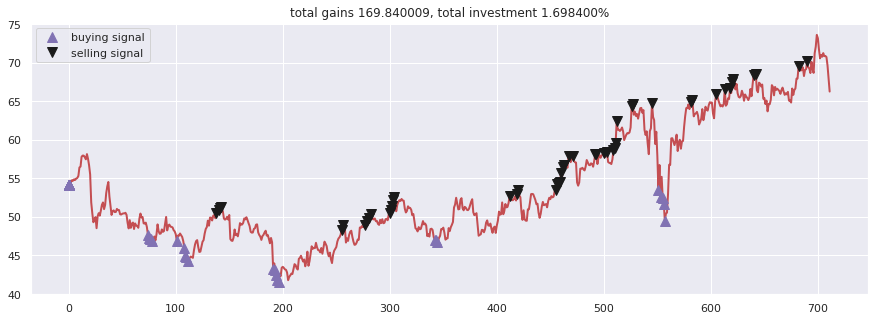

In [ ]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()


## Moving Average agent

In [ ]:
df= df_full_test.copy()
name = 'Moving Average agent'

short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,54.160000,54.160000,NaN
1,0.0,54.420000,54.420000,0.0
2,0.0,54.443334,54.443334,0.0
3,0.0,54.517501,54.517501,0.0
4,0.0,54.552001,54.552001,0.0
...,...,...,...,...
707,1.0,70.734706,69.204286,0.0
708,1.0,70.811765,69.366000,0.0
709,1.0,70.835294,69.495714,0.0
710,1.0,70.793529,69.584857,0.0


In [ ]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory
    daily_returns = []
    daily_returns.append(0)
    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        initial_money_hold = initial_money
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
        returns = (initial_money/initial_money_hold - 1)*100
        daily_returns.append(returns)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, daily_returns

In [ ]:
states_buy, states_sell, total_gains, invest, daily_returns = buy_stock(df.Close, signals['positions'])

day 17: buy 1 units at price 58.139999, total balance 9941.860001
day 26, sell 1 units at price 48.520000, investment -16.546266 %, total balance 9990.380001,
day 98: buy 1 units at price 48.270000, total balance 9942.110001
day 109, sell 1 units at price 44.930000, investment -6.919412 %, total balance 9987.040001,
day 131: buy 1 units at price 48.840000, total balance 9938.200001
day 158, sell 1 units at price 47.459999, investment -2.825555 %, total balance 9985.660000,
day 176: buy 1 units at price 49.020000, total balance 9936.640000
day 181, sell 1 units at price 47.500000, investment -3.100775 %, total balance 9984.140000,
day 222: buy 1 units at price 44.169998, total balance 9939.970002
day 326, sell 1 units at price 48.099998, investment 8.897442 %, total balance 9988.070000,
day 361: buy 1 units at price 51.590000, total balance 9936.480000
day 387, sell 1 units at price 48.279999, investment -6.415974 %, total balance 9984.759999,
day 408: buy 1 units at price 51.660000, to

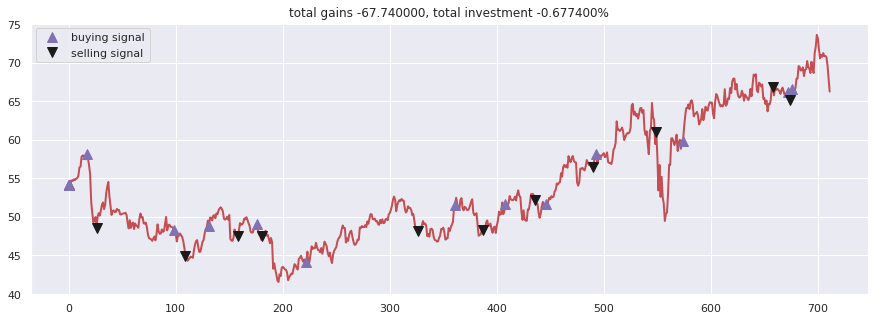

In [ ]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## Signal Rolling agent

In [ ]:
df= df_full_test.copy()
name = 'Signal Rolling agent'

In [ ]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    daily_returns = []
    daily_returns.append(0)
    for i in range(1, real_movement.shape[0], 1):
        initial_money_hold = initial_money
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
        returns = (initial_money/initial_money_hold - 1)*100
        daily_returns.append(returns)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, daily_returns

In [ ]:
states_buy, states_sell, total_gains, invest, daily_returns = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 4, initial_money = 10000)

day 0: buy 1 units at price 54.160000, total balance 9945.840000
day 8, sell 1 units at price 55.040001, investment 1.624817 %, total balance 10000.880001,
day 19: buy 1 units at price 56.680000, total balance 9944.200001
day 30, sell 1 units at price 50.799999, investment -10.374031 %, total balance 9995.000000,
day 43: buy 1 units at price 50.610001, total balance 9944.389999
day 53, sell 1 units at price 50.520000, investment -0.177832 %, total balance 9994.909999,
day 61: buy 1 units at price 48.410000, total balance 9946.499999
day 72, sell 1 units at price 49.240002, investment 1.714526 %, total balance 9995.740001,
day 77: buy 1 units at price 47.080002, total balance 9948.659999
day 86, sell 1 units at price 47.830002, investment 1.593033 %, total balance 9996.490001,
day 97: buy 1 units at price 48.619999, total balance 9947.870002
day 114, sell 1 units at price 44.840000, investment -7.774576 %, total balance 9992.710002,
day 131: buy 1 units at price 48.840000, total balance

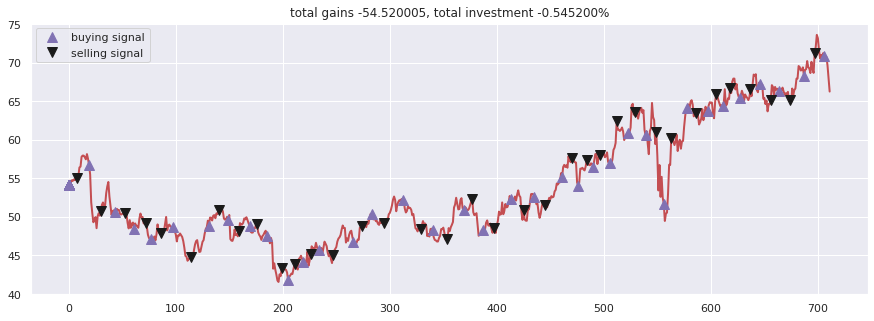

In [ ]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## Policy Gradient agent

In [ ]:
df = df_full.copy()
name = 'Policy Gradient agent'
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            initial_money_hold = initial_money
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = ITER, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch: 10, total rewards: 19.031994.3, cost: -33462.824219, total money: 10019.031994
epoch: 20, total rewards: 82.393996.3, cost: -33853.636719, total money: 10082.393996
epoch: 30, total rewards: 509.380029.3, cost: -34483.835938, total money: 10509.380029
epoch: 40, total rewards: 1923.904021.3, cost: -32515.779297, total money: 10981.644025
epoch: 50, total rewards: 1922.324026.3, cost: -30460.748047, total money: 9284.304019
epoch: 60, total rewards: 2220.516026.3, cost: -31455.041016, total money: 10561.876023
epoch: 70, total rewards: 2234.828025.3, cost: -31238.462891, total money: 10120.188021
epoch: 80, total rewards: 1858.118052.3, cost: -32320.658203, total money: 10452.378043
epoch: 90, total rewards: 1760.780037.3, cost: -31099.332031, total money: 9586.090027
epoch: 100, total rewards: 1711.544015.3, cost: -32143.814453, total money: 10445.364

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 54.160000, total balance 9945.840000
day 1, sell 1 unit at price 54.680000, investment 0.960118 %, total balance 10000.520000,
day 2: buy 1 unit at price 54.490002, total balance 9946.029998
day 3, sell 1 unit at price 54.740002, investment 0.458800 %, total balance 10000.770000,
day 4: buy 1 unit at price 54.689999, total balance 9946.080001
day 5: buy 1 unit at price 54.860001, total balance 9891.220000
day 6: buy 1 unit at price 54.790001, total balance 9836.429999
day 7: buy 1 unit at price 54.959999, total balance 9781.470000
day 8: buy 1 unit at price 55.040001, total balance 9726.429999
day 9: buy 1 unit at price 55.310001, total balance 9671.119998
day 11, sell 1 unit at price 56.509998, investment 3.327846 %, total balance 9727.629996,
day 12, sell 1 unit at price 57.790001, investment 5.340868 %, total balance 9785.419997,
day 13: buy 1 unit at price 57.950001, total balance 9727.469996
day 15: buy 1 unit at price 57.730000, total balance 9669.73999

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,0.2%
Cumulative returns,0.5%
Annual volatility,7.2%
Sharpe ratio,0.06
Calmar ratio,0.02
Stability,0.15
Max drawdown,-9.6%


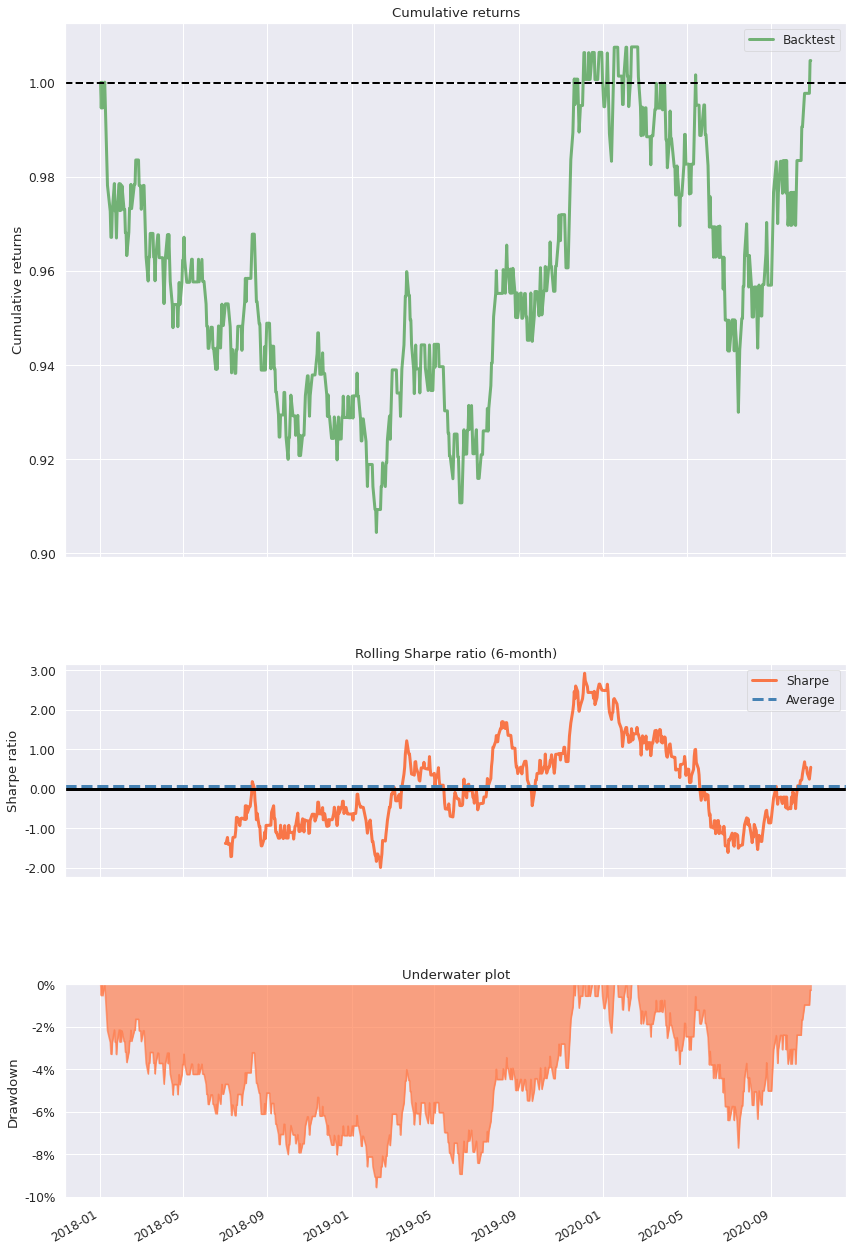

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

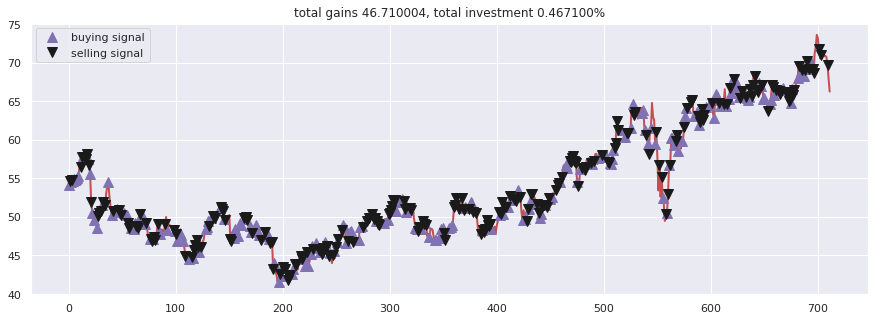

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## Q-learning agent

In [ ]:
from collections import deque
import random

df= df_full.copy()
name = 'Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = ITER, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 4.425985.3, cost: 0.026508, total money: 10004.425985
epoch: 20, total rewards: -3.666024.3, cost: 0.030135, total money: 9996.333976
epoch: 30, total rewards: 4.837997.3, cost: 0.021546, total money: 10004.837997
epoch: 40, total rewards: 0.122006.3, cost: 0.022104, total money: 10000.122006
epoch: 50, total rewards: 1.742015.3, cost: 0.017272, total money: 10001.742015
epoch: 60, total rewards: 1.367999.3, cost: 0.016809, total money: 10001.367999
epoch: 70, total rewards: 6.031993.3, cost: 0.016777, total money: 10006.031993
epoch: 80, total rewards: -1.688001.3, cost: 0.010324, total money: 9998.311999
epoch: 90, total rewards: 9.260003.3, cost: 0.011307, total money: 10009.260003
epoch: 100, total rewards: 11.690002.3, cost: 0.010123, total money: 10011.690002
epoch: 110, total rewards: 8.487998.3, cost: 0.010022, total money: 10008.487998
epoch: 120, total rewards: 14.161999.3, cost: 0.008364, total money: 10014.161999
epoch: 130, total rewards: 11.13400

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy(initial_money = initial_money)

day 6: buy 1 unit at price 54.790001, total balance 9945.209999
day 8: buy 1 unit at price 55.040001, total balance 9890.169998
day 9, sell 1 unit at price 55.310001, investment 0.949078 %, total balance 9945.479999,
day 10: buy 1 unit at price 56.410000, total balance 9889.069999
day 11, sell 1 unit at price 56.509998, investment 2.670779 %, total balance 9945.579997,
day 12: buy 1 unit at price 57.790001, total balance 9887.789996
day 13, sell 1 unit at price 57.950001, investment 2.730014 %, total balance 9945.739997,
day 14: buy 1 unit at price 57.939999, total balance 9887.799998
day 15: buy 1 unit at price 57.730000, total balance 9830.069998
day 16: buy 1 unit at price 57.459999, total balance 9772.609999
day 17: buy 1 unit at price 58.139999, total balance 9714.470000
day 18: buy 1 unit at price 57.529999, total balance 9656.940001
day 19: buy 1 unit at price 56.680000, total balance 9600.260001
day 20: buy 1 unit at price 55.500000, total balance 9544.760001
day 21, sell 1 uni

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,-0.2%
Cumulative returns,-0.4%
Annual volatility,5.2%
Sharpe ratio,-0.00
Calmar ratio,-0.03
Stability,0.03
Max drawdown,-4.6%


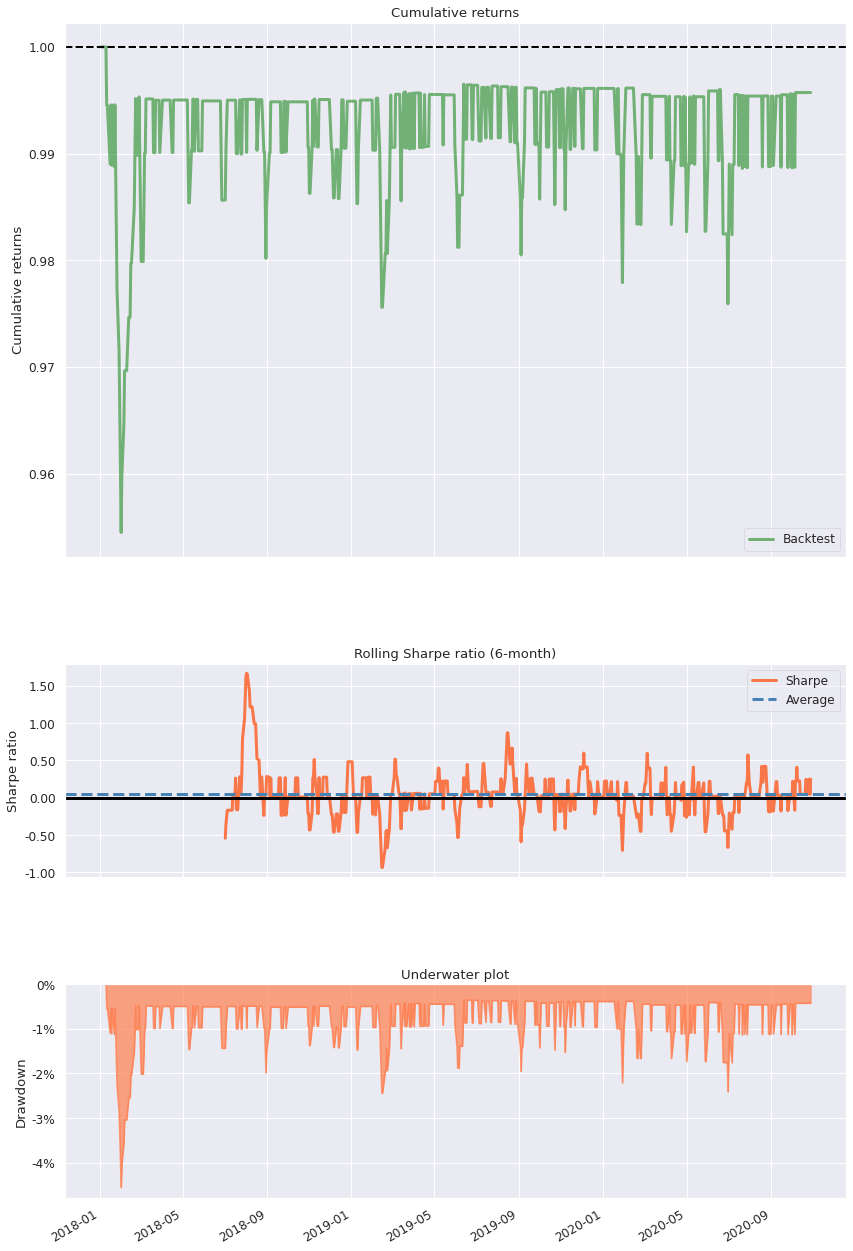

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

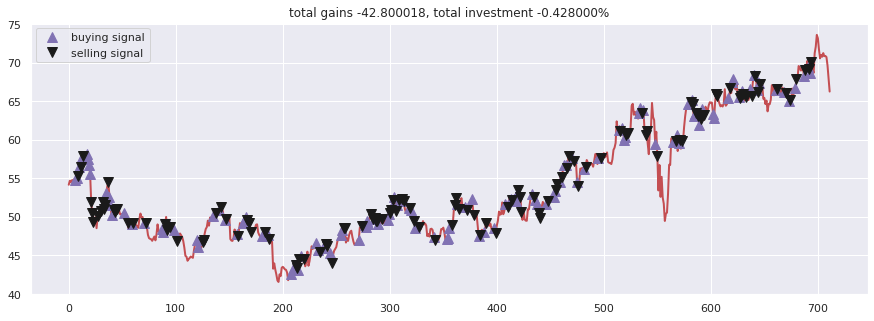

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## F-Q Learning

In [ ]:
from collections import deque
import random
from scipy.special import softmax

df= df_full.copy()
name = 'F-Q learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    # def act(self, state):
    #     if random.random() <= self.epsilon:
    #         return random.randrange(self.action_size)
    #     return np.argmax(
    #         self.sess.run(self.logits, feed_dict = {self.X: state})[0]
    #     )

    def act(self, state):
      tmp = self.sess.run(self.logits, feed_dict = {self.X: state})[0]
      tmp = np.cumsum(softmax(tmp*10))
      rnd_var = random.random()
      if rnd_var <= tmp[0]:
        return 0
      elif rnd_var <= tmp[1]:
        return 1
      else:
        return 2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            if action == 1:
              target[1] = reward
              target[2] = 0
              if not done:
                  target[1] += self.gamma * np.amax(Q_new[i])
            elif action == 2:
              target[2] = reward
              target[1] = 0
              if not done:
                  target[2] += self.gamma * np.amax(Q_new[i]) 
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = ITER, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 398.650004.3, cost: 0.061769, total money: 7604.850001
epoch: 20, total rewards: 772.824003.3, cost: 0.039445, total money: 8949.344003
epoch: 30, total rewards: 327.331986.3, cost: 0.034665, total money: 9333.111983
epoch: 40, total rewards: 505.779990.3, cost: 0.024925, total money: 9953.239985
epoch: 50, total rewards: 294.190009.3, cost: 0.025804, total money: 9260.120013
epoch: 60, total rewards: 82.474027.3, cost: 0.027730, total money: 9575.234022
epoch: 70, total rewards: 191.404003.3, cost: 0.025858, total money: 9642.743995
epoch: 80, total rewards: 274.236018.3, cost: 0.023395, total money: 9527.186014
epoch: 90, total rewards: 383.481999.3, cost: 0.014408, total money: 10030.561993
epoch: 100, total rewards: 140.136047.3, cost: 0.017181, total money: 9590.156043
epoch: 110, total rewards: 183.526026.3, cost: 0.014816, total money: 10183.526026
epoch: 120, total rewards: 122.624010.3, cost: 0.016305, total money: 9817.074007
epoch: 130, total reward

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 54.860001, total balance 9945.139999
day 6, sell 1 unit at price 54.790001, investment -0.127598 %, total balance 9999.930000,
day 14: buy 1 unit at price 57.939999, total balance 9941.990001
day 15, sell 1 unit at price 57.730000, investment -0.362442 %, total balance 9999.720001,
day 17: buy 1 unit at price 58.139999, total balance 9941.580002
day 18: buy 1 unit at price 57.529999, total balance 9884.050003
day 19: buy 1 unit at price 56.680000, total balance 9827.370003
day 21: buy 1 unit at price 51.869999, total balance 9775.500004
day 22: buy 1 unit at price 50.470001, total balance 9725.030003
day 23: buy 1 unit at price 49.290001, total balance 9675.740002
day 24: buy 1 unit at price 49.529999, total balance 9626.210003
day 25, sell 1 unit at price 49.959999, investment -14.069488 %, total balance 9676.170002,
day 26: buy 1 unit at price 48.520000, total balance 9627.650002
day 27, sell 1 unit at price 50.070000, investment -12.967146 %, total balance

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,0.0%
Cumulative returns,0.1%
Annual volatility,5.7%
Sharpe ratio,0.03
Calmar ratio,0.01
Stability,0.06
Max drawdown,-5.8%


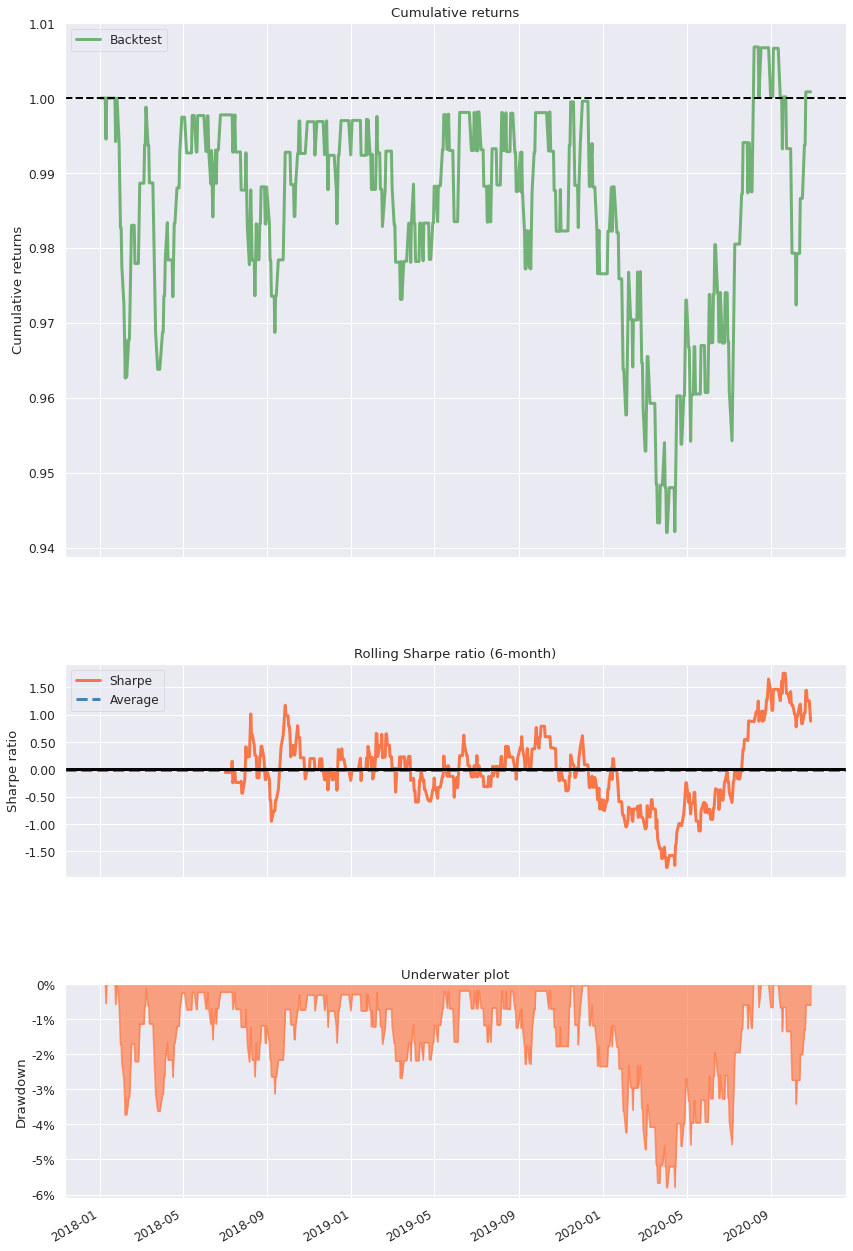

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

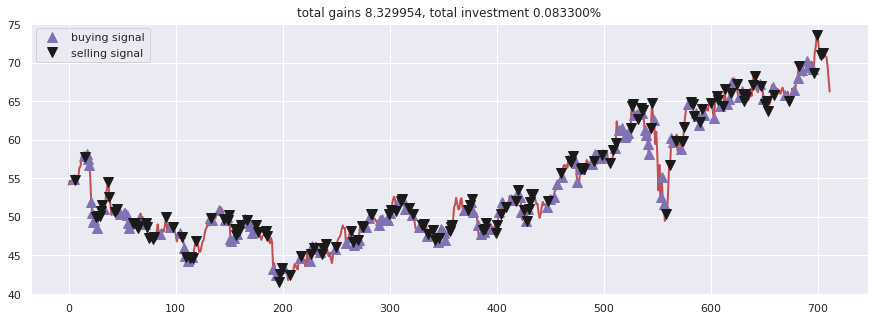

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## F-Q with choice trace

In [ ]:
from collections import deque
import random

df= df_full.copy()
name = 'F-Q with choice trace learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        buy_action = 0
        sell_action = 0
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            if action == 1:
              buy_action += 0.001
              sell_action -= 0.001
              target[1] = reward - buy_action
              target[2] = 0
              if not done:
                  target[1] += self.gamma * np.amax(Q_new[i])
            elif action == 2:
              buy_action -= 0.001
              sell_action += 0.001
              target[2] = reward - sell_action
              target[1] = 0
              if not done:
                  target[2] += self.gamma * np.amax(Q_new[i])   
            else:
              target[1] = 0
              target[2] = 0         
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = ITER, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 17.335993.3, cost: 0.029368, total money: 10017.335993
epoch: 20, total rewards: 29.813984.3, cost: 0.027212, total money: 10029.813984
epoch: 30, total rewards: 45.533969.3, cost: 0.024471, total money: 10045.533969
epoch: 40, total rewards: 96.203945.3, cost: 0.021898, total money: 10096.203945
epoch: 50, total rewards: 209.059938.3, cost: 0.021250, total money: 10209.059938
epoch: 60, total rewards: 265.503948.3, cost: 0.020521, total money: 10265.503948
epoch: 70, total rewards: 271.427942.3, cost: 0.019773, total money: 10271.427942
epoch: 80, total rewards: 251.057948.3, cost: 0.018625, total money: 10251.057948
epoch: 90, total rewards: 305.093936.3, cost: 0.018024, total money: 10305.093936
epoch: 100, total rewards: 340.187927.3, cost: 0.018062, total money: 10340.187927
epoch: 110, total rewards: 480.391925.3, cost: 0.017824, total money: 10480.391925
epoch: 120, total rewards: 572.331937.3, cost: 0.020648, total money: 10572.331937
epoch: 130, total

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 54.160000, total balance 9945.840000
day 2: buy 1 unit at price 54.490002, total balance 9891.349998
day 4: buy 1 unit at price 54.689999, total balance 9836.659999
day 11, sell 1 unit at price 56.509998, investment 4.338992 %, total balance 9893.169997,
day 13, sell 1 unit at price 57.950001, investment 6.349787 %, total balance 9951.119998,
day 18: buy 1 unit at price 57.529999, total balance 9893.589999
day 19, sell 1 unit at price 56.680000, investment 3.638693 %, total balance 9950.269999,
day 21, sell 1 unit at price 51.869999, investment -9.838345 %, total balance 10002.139998,
day 22: buy 1 unit at price 50.470001, total balance 9951.669997
day 23, sell 1 unit at price 49.290001, investment -2.338023 %, total balance 10000.959998,
day 34: buy 1 unit at price 51.529999, total balance 9949.429999
day 38, sell 1 unit at price 52.630001, investment 2.134683 %, total balance 10002.060000,
day 43: buy 1 unit at price 50.610001, total balance 9951.449999
day

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,0.1%
Cumulative returns,0.3%
Annual volatility,5.1%
Sharpe ratio,0.04
Calmar ratio,0.02
Stability,0.08
Max drawdown,-4.6%


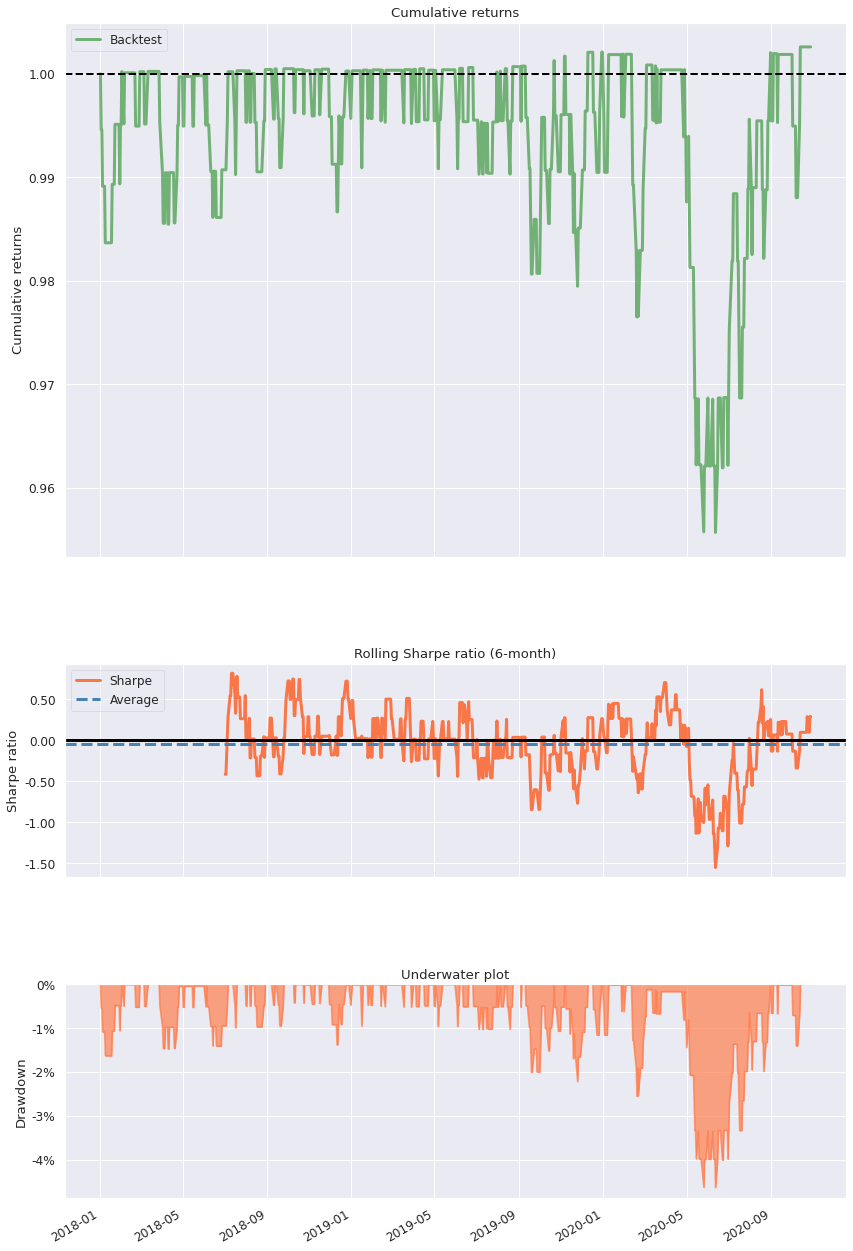

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

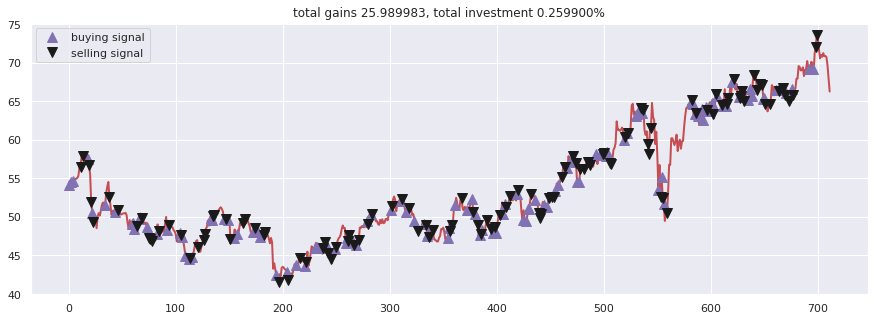

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig(name+'.png')
plt.show()

## F-Q greedy learning

In [ ]:
from collections import deque
import random

df= df_full.copy()
name = 'F-Q greedy learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            if action == 1:
              target[1] = reward
              target[2] = 0
              if not done:
                  target[1] += self.gamma * np.amax(Q_new[i])
            elif action == 2:
              target[2] = reward
              target[1] = 0
              if not done:
                  target[2] += self.gamma * np.amax(Q_new[i])   
            else:
              target[1] = 0
              target[2] = 0         
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                starting_money_hold = starting_money

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = ITER, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 1440.994003.3, cost: 0.266219, total money: 1651.224006
epoch: 20, total rewards: -46.795999.3, cost: 0.058149, total money: 7708.014003
epoch: 30, total rewards: -51.852020.3, cost: 0.041348, total money: 8658.857982
epoch: 40, total rewards: -45.378010.3, cost: 0.034877, total money: 9113.851988
epoch: 50, total rewards: -13.154015.3, cost: 0.033170, total money: 9145.435984
epoch: 60, total rewards: -16.600027.3, cost: 0.027288, total money: 9578.969972
epoch: 70, total rewards: 47.507967.3, cost: 0.025208, total money: 9643.077966
epoch: 80, total rewards: 103.759975.3, cost: 0.026320, total money: 9358.939970
epoch: 90, total rewards: 74.867966.3, cost: 0.024743, total money: 9283.507960
epoch: 100, total rewards: 42.439971.3, cost: 0.021367, total money: 9591.189967
epoch: 110, total rewards: 107.835981.3, cost: 0.021351, total money: 9607.525976
epoch: 120, total rewards: 79.185971.3, cost: 0.021486, total money: 9335.945964
epoch: 130, total rewards: 3

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 54.959999, total balance 9945.040001
day 9, sell 1 unit at price 55.310001, investment 0.636830 %, total balance 10000.350002,
day 15: buy 1 unit at price 57.730000, total balance 9942.620002
day 16: buy 1 unit at price 57.459999, total balance 9885.160003
day 18, sell 1 unit at price 57.529999, investment -0.346442 %, total balance 9942.690002,
day 19, sell 1 unit at price 56.680000, investment -1.357464 %, total balance 9999.370002,
day 20: buy 1 unit at price 55.500000, total balance 9943.870002
day 21, sell 1 unit at price 51.869999, investment -6.540542 %, total balance 9995.740001,
day 22: buy 1 unit at price 50.470001, total balance 9945.270000
day 23: buy 1 unit at price 49.290001, total balance 9895.979999
day 24, sell 1 unit at price 49.529999, investment -1.862496 %, total balance 9945.509998,
day 25: buy 1 unit at price 49.959999, total balance 9895.549999
day 26: buy 1 unit at price 48.520000, total balance 9847.029999
day 27: buy 1 unit at price

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,-0.5%
Cumulative returns,-1.5%
Annual volatility,6.7%
Sharpe ratio,-0.04
Calmar ratio,-0.07
Stability,0.18
Max drawdown,-7.4%


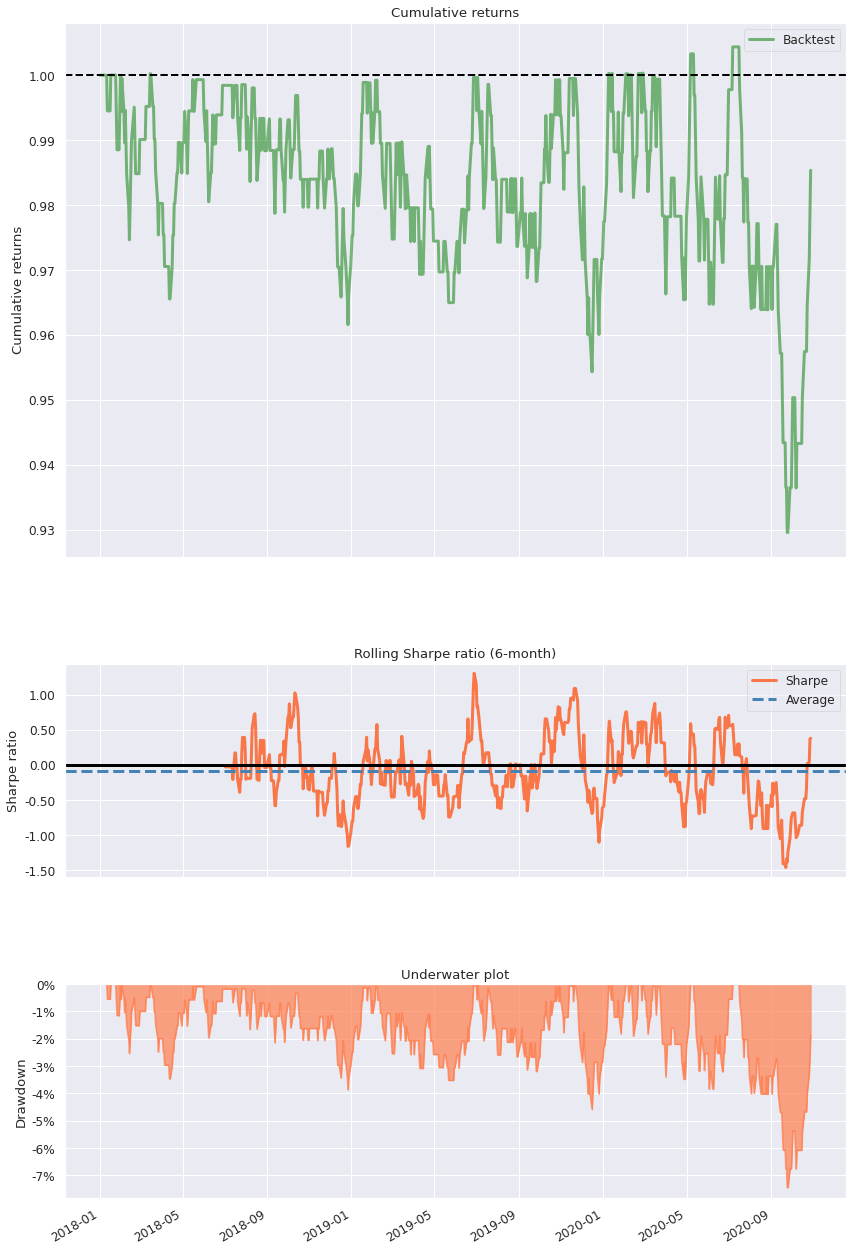

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

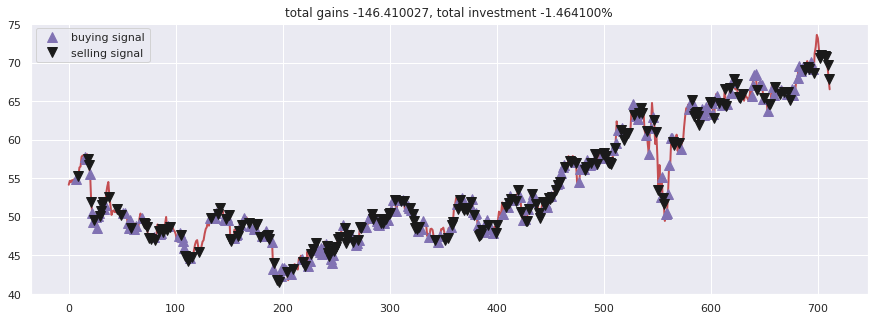

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
# plt.savefig(name+'.png')
plt.show()

## Evolution Strategy agent

In [ ]:
import pkg_resources
import types
import time

df= df_full.copy()
name = 'Evolution Strategy agent'


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

tensorflow==2.3.0
seaborn==0.11.0
pyfolio==0.9.2
pandas==1.1.3
numpy==1.18.5
matplotlib==3.2.2
google==2.0.3


In [ ]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [ ]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns

In [ ]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = ITER*3, checkpoint = 10)

iter 10. reward: 2.451400
iter 20. reward: 3.645300
iter 30. reward: 7.457300
iter 40. reward: 6.688000
iter 50. reward: 4.564100
iter 60. reward: 4.808500
iter 70. reward: 5.938000
iter 80. reward: 9.151800
iter 90. reward: 7.152800
iter 100. reward: 5.186600
iter 110. reward: 9.152200
iter 120. reward: 8.773800
iter 130. reward: 8.211100
iter 140. reward: 9.890600
iter 150. reward: 8.406500
iter 160. reward: 9.750200
iter 170. reward: 12.059900
iter 180. reward: 11.296800
iter 190. reward: 9.739600
iter 200. reward: 9.518600
iter 210. reward: 10.690400
iter 220. reward: 12.831500
iter 230. reward: 9.168400
iter 240. reward: 11.857300
iter 250. reward: 11.611600
iter 260. reward: 11.068800
iter 270. reward: 12.450900
iter 280. reward: 11.676400
iter 290. reward: 11.340700
iter 300. reward: 10.863200
iter 310. reward: 13.459300
iter 320. reward: 11.079000
iter 330. reward: 8.193800
iter 340. reward: 14.615300
iter 350. reward: 12.405300
iter 360. reward: 9.658200
iter 370. reward: 12.9

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy()

day 0: buy 1 unit at price 54.160000, total balance 9945.840000
day 1: buy 1 unit at price 54.680000, total balance 9891.160000
day 2: buy 1 unit at price 54.490002, total balance 9836.669998
day 3: buy 1 unit at price 54.740002, total balance 9781.929996
day 4: buy 1 unit at price 54.689999, total balance 9727.239997
day 5: buy 1 unit at price 54.860001, total balance 9672.379996
day 6, sell 1 unit at price 54.790001, investment 1.163222 %, total balance 9727.169997,
day 7: buy 1 unit at price 54.959999, total balance 9672.209998
day 8, sell 1 unit at price 55.040001, investment 0.658378 %, total balance 9727.249999,
day 9, sell 1 unit at price 55.310001, investment 1.504861 %, total balance 9782.560000,
day 11, sell 1 unit at price 56.509998, investment 3.233460 %, total balance 9839.069998,
day 13, sell 1 unit at price 57.950001, investment 5.960874 %, total balance 9897.019999,
day 14, sell 1 unit at price 57.939999, investment 5.614287 %, total balance 9954.959998,
day 15, sell 1 

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,5.5%
Cumulative returns,16.4%
Annual volatility,10.7%
Sharpe ratio,0.56
Calmar ratio,0.10
Stability,0.11
Max drawdown,-53.8%


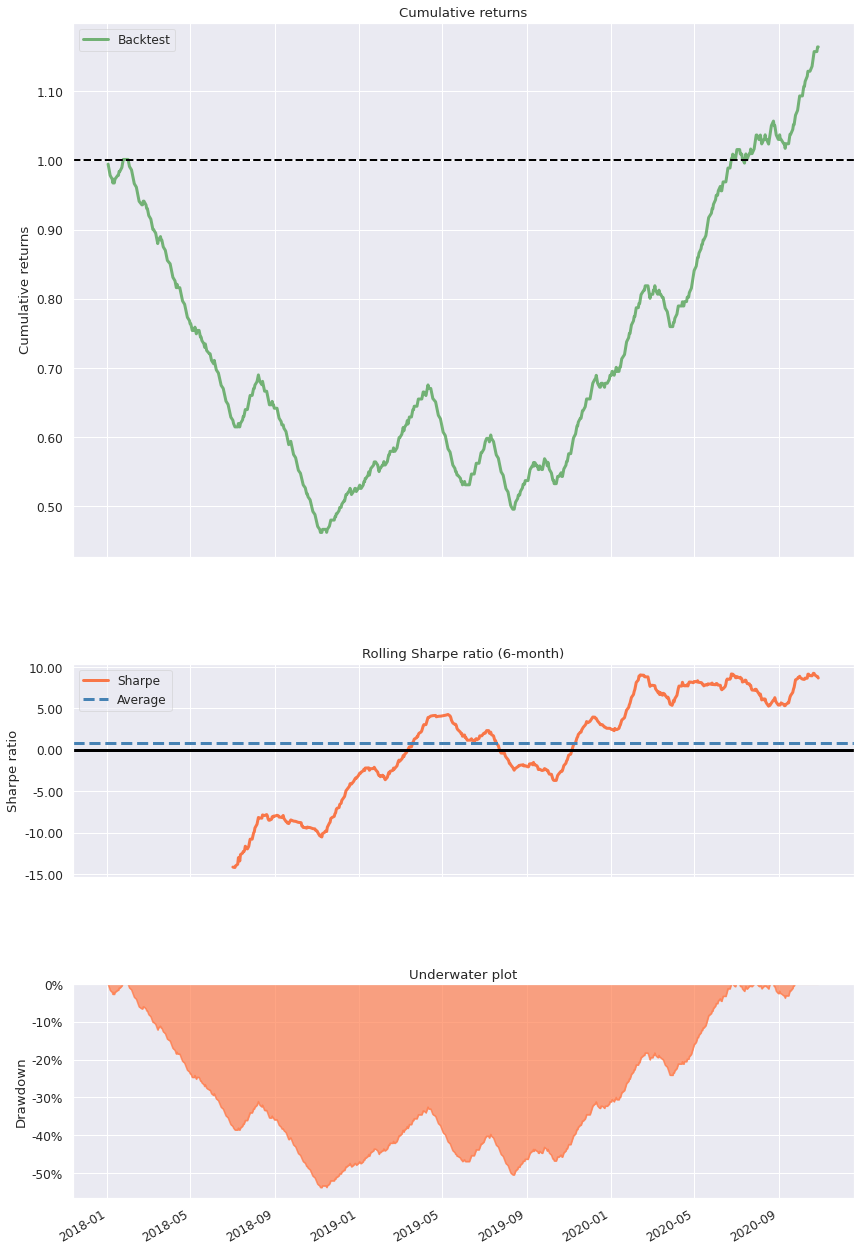

In [ ]:
daily_returns.append(0)
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

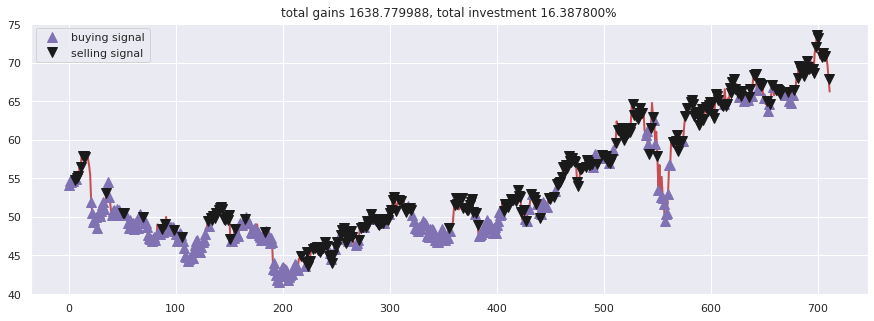

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## Double Q-learning agent

In [ ]:
from collections import deque
import random

df= df_full.copy()
name = 'Double Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = ITER, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 303.131971.3, cost: 0.002136, total money: 10249.721971
epoch: 20, total rewards: 289.121930.3, cost: 0.010397, total money: 10182.721932
epoch: 30, total rewards: 174.321912.3, cost: 0.003918, total money: 10068.081914
epoch: 40, total rewards: 618.226051.3, cost: 0.009165, total money: 10457.666049
epoch: 50, total rewards: 92.796072.3, cost: 0.000888, total money: 9985.486070
epoch: 60, total rewards: 75.139986.3, cost: 0.000239, total money: 10075.139986
epoch: 70, total rewards: 34.264027.3, cost: 0.001751, total money: 9874.864029
epoch: 80, total rewards: 109.854033.3, cost: 0.003366, total money: 10109.854033
epoch: 90, total rewards: 83.572025.3, cost: 0.001623, total money: 10083.572025
epoch: 100, total rewards: -17.163916.3, cost: 0.000477, total money: 9929.256082
epoch: 110, total rewards: -39.534014.3, cost: 0.000104, total money: 9906.735986
epoch: 120, total rewards: 55.022026.3, cost: 0.000650, total money: 10055.022026
epoch: 130, total rewa

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy(initial_money = initial_money)

day 9: buy 1 unit at price 55.310001, total balance 9944.689999
day 10, sell 1 unit at price 56.410000, investment 1.988789 %, total balance 10001.099999,
day 11: buy 1 unit at price 56.509998, total balance 9944.590001
day 13: buy 1 unit at price 57.950001, total balance 9886.640000
day 14, sell 1 unit at price 57.939999, investment 2.530527 %, total balance 9944.579999,
day 15, sell 1 unit at price 57.730000, investment -0.379639 %, total balance 10002.309999,
day 19: buy 1 unit at price 56.680000, total balance 9945.629999
day 20, sell 1 unit at price 55.500000, investment -2.081863 %, total balance 10001.129999,
day 33: buy 1 unit at price 50.990002, total balance 9950.139997
day 34, sell 1 unit at price 51.529999, investment 1.059025 %, total balance 10001.669996,
day 41: buy 1 unit at price 50.730000, total balance 9950.939996
day 44, sell 1 unit at price 50.630001, investment -0.197120 %, total balance 10001.569997,
day 46: buy 1 unit at price 50.869999, total balance 9950.69999

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,0.2%
Cumulative returns,0.6%
Annual volatility,5.1%
Sharpe ratio,0.07
Calmar ratio,0.03
Stability,0.02
Max drawdown,-6.6%


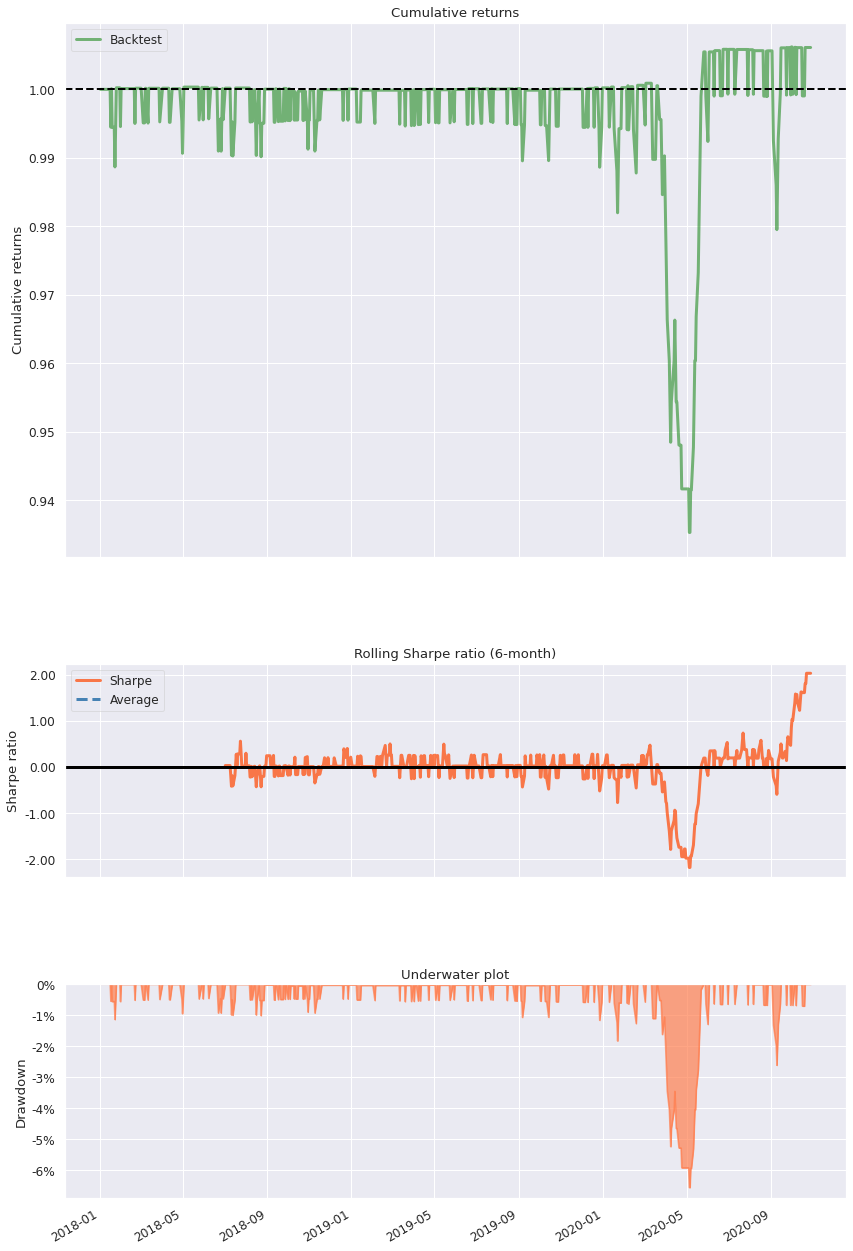

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

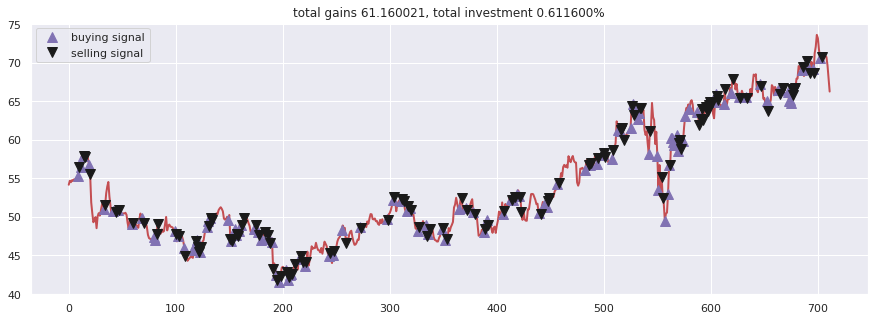

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## Duel Q-learning agent

In [ ]:
from collections import deque
import random

df= df_full.copy()
name = 'Duel Q-learning agent'

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 512, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, self.action_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = ITER, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 3596.845990.3, cost: 0.196641, total money: 288.354014
epoch: 20, total rewards: 1471.022013.3, cost: 0.150170, total money: 303.452021
epoch: 30, total rewards: 213.212027.3, cost: 0.144092, total money: 389.182020
epoch: 40, total rewards: -27.159986.3, cost: 0.125355, total money: 895.700006
epoch: 50, total rewards: -354.817987.3, cost: 0.120548, total money: 1222.892002
epoch: 60, total rewards: -294.087983.3, cost: 0.120536, total money: 1434.922005
epoch: 70, total rewards: -634.781989.3, cost: 0.109887, total money: 1879.007999
epoch: 80, total rewards: -645.783992.3, cost: 0.120937, total money: 1689.305999
epoch: 90, total rewards: -728.851994.3, cost: 0.121025, total money: 1762.717996
epoch: 100, total rewards: -729.727976.3, cost: 0.096958, total money: 2475.132014
epoch: 110, total rewards: -737.263980.3, cost: 0.099330, total money: 2465.656012
epoch: 120, total rewards: -897.793979.3, cost: 0.103372, total money: 2384.856014
epoch: 130, total r

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy(initial_money = initial_money)

day 30: buy 1 unit at price 50.799999, total balance 9949.200001
day 31: buy 1 unit at price 51.560001, total balance 9897.640000
day 32, sell 1 unit at price 51.860001, investment 2.086618 %, total balance 9949.500001,
day 34: buy 1 unit at price 51.529999, total balance 9897.970002
day 35: buy 1 unit at price 53.060001, total balance 9844.910001
day 36: buy 1 unit at price 53.930000, total balance 9790.980001
day 37: buy 1 unit at price 54.520000, total balance 9736.460001
day 41: buy 1 unit at price 50.730000, total balance 9685.730001
day 43: buy 1 unit at price 50.610001, total balance 9635.120000
day 44, sell 1 unit at price 50.630001, investment -1.803724 %, total balance 9685.750001,
day 46: buy 1 unit at price 50.869999, total balance 9634.880002
day 48: buy 1 unit at price 50.330002, total balance 9584.550000
day 49: buy 1 unit at price 50.290001, total balance 9534.259999
day 50, sell 1 unit at price 50.389999, investment -2.212304 %, total balance 9584.649998,
day 51: buy 1

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,-31.5%
Cumulative returns,-65.7%
Annual volatility,12.6%
Sharpe ratio,-2.95
Calmar ratio,-0.46
Stability,0.90
Max drawdown,-67.8%


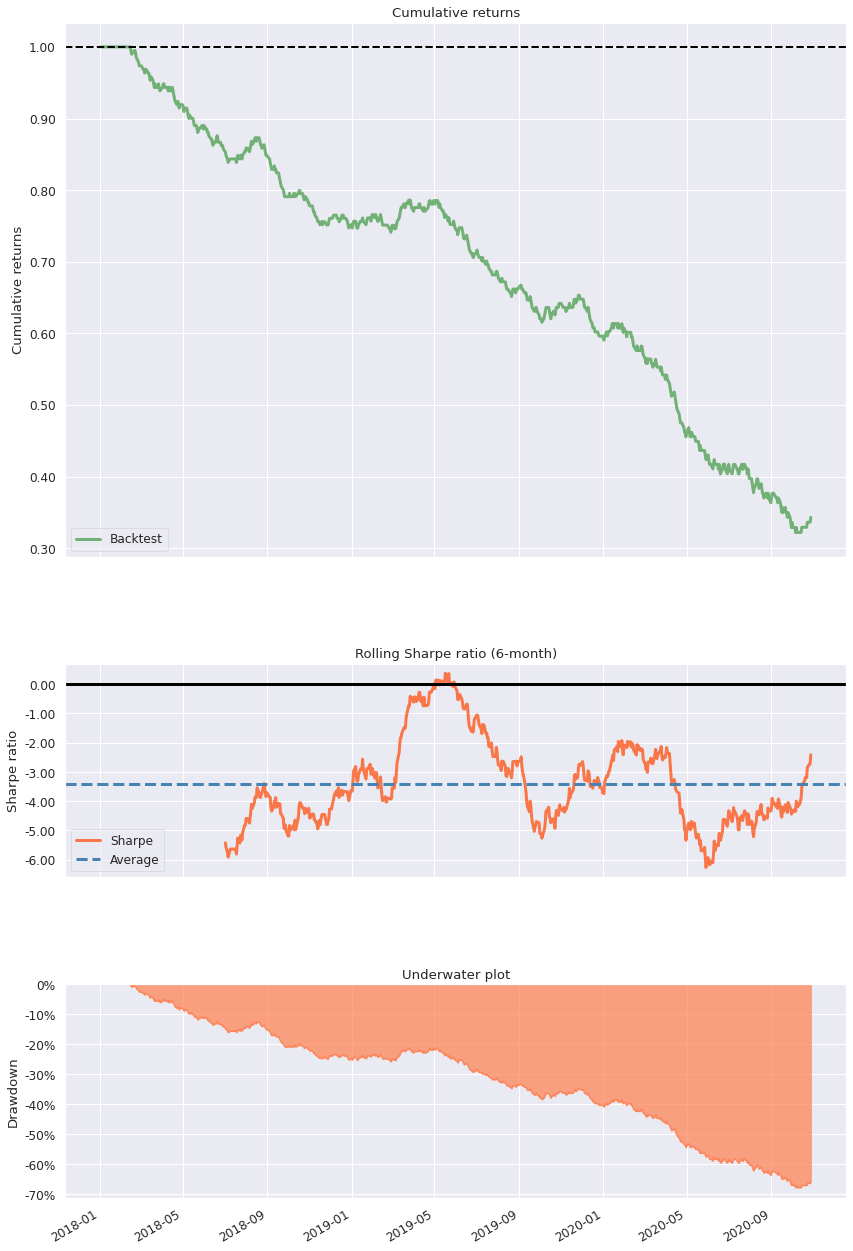

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

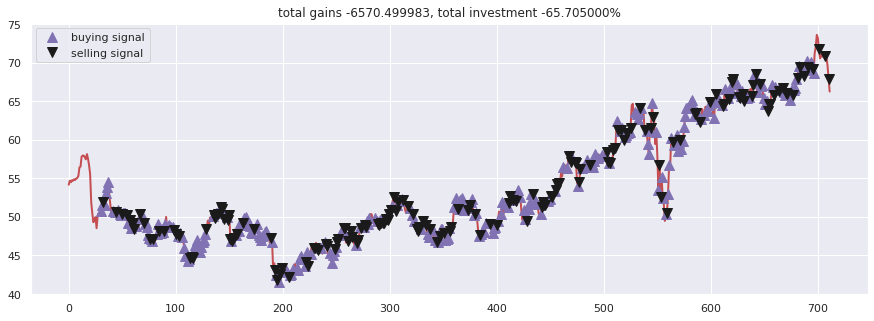

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## Actor-critic agent

In [ ]:
from collections import deque
import random

df= df_full.copy()
name = 'Actor-critic agent'

class Actor:
    def __init__(self, name, input_size, output_size, size_layer):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            feed_actor = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_actor, output_size)

class Critic:
    def __init__(self, name, input_size, output_size, size_layer, learning_rate):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            self.REWARD = tf.placeholder(tf.float32, (None, 1))
            feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            feed_critic = tf.layers.dense(feed_critic, output_size, activation = tf.nn.relu) + self.Y
            feed_critic = tf.layers.dense(feed_critic, size_layer//2, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_critic, 1)
            self.cost = tf.reduce_mean(tf.square(self.REWARD - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
            
class Agent:

    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.actor = Actor('actor-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.actor_target = Actor('actor-target', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.critic = Critic('critic-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.critic_target = Critic('critic-target', self.state_size, self.OUTPUT_SIZE, 
                                    self.LAYER_SIZE, self.LEARNING_RATE)
        self.grad_critic = tf.gradients(self.critic.logits, self.critic.Y)
        self.actor_critic_grad = tf.placeholder(tf.float32, [None, self.OUTPUT_SIZE])
        weights_actor = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.grad_actor = tf.gradients(self.actor.logits, weights_actor, -self.actor_critic_grad)
        grads = zip(self.grad_actor, weights_actor)
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)
            
    def _memorize(self, state, action, reward, new_state, dead):
        self.MEMORIES.append((state, action, reward, new_state, dead))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            prediction = self.sess.run(self.actor.logits, feed_dict={self.actor.X:[state]})[0]
            action = np.argmax(prediction)
        return action
    
    def _construct_memories_and_train(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.sess.run(self.actor.logits, feed_dict={self.actor.X: states})
        Q_target = self.sess.run(self.actor_target.logits, feed_dict={self.actor_target.X: states})
        grads = self.sess.run(self.grad_critic, feed_dict={self.critic.X:states, self.critic.Y:Q})[0]
        self.sess.run(self.optimizer, feed_dict={self.actor.X:states, self.actor_critic_grad:grads})
        
        rewards = np.array([a[2] for a in replay]).reshape((-1, 1))
        rewards_target = self.sess.run(self.critic_target.logits, 
                                       feed_dict={self.critic_target.X:new_states,self.critic_target.Y:Q_target})
        for i in range(len(replay)):
            if not replay[0][-1]:
                rewards[i] += self.GAMMA * rewards_target[i]
        cost, _ = self.sess.run([self.critic.cost, self.critic.optimizer], 
                                feed_dict={self.critic.X:states, self.critic.Y:Q, self.critic.REWARD:rewards})
        return cost
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('actor-original', 'actor-target')
                    self._assign('critic-original', 'critic-target')
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                state = next_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories_and_train(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = ITER, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 432.015997.3, cost: 7851772.500000, total money: 10073.405997
epoch: 20, total rewards: 2157.964035.3, cost: 10840627.000000, total money: 2904.974017
epoch: 30, total rewards: 1675.368043.3, cost: 620865.562500, total money: 3615.078036
epoch: 40, total rewards: 4199.794028.3, cost: 73.949364, total money: 80.214050
epoch: 50, total rewards: 3601.236032.3, cost: 80.726608, total money: 0.406053
epoch: 60, total rewards: 5255.685979.3, cost: 88.420731, total money: 49.435966
epoch: 70, total rewards: 5714.842006.3, cost: 92.699356, total money: 16.366021
epoch: 80, total rewards: 5732.647955.3, cost: 97.444778, total money: 31.279929
epoch: 90, total rewards: 5822.890025.3, cost: 102.341469, total money: 90.688047
epoch: 100, total rewards: 5877.060006.3, cost: 107.896904, total money: 149.203988
epoch: 110, total rewards: 5486.840013.3, cost: 86.331421, total money: 20.536025
epoch: 120, total rewards: 5801.816011.3, cost: 81.076706, total money: 36.452006
ep

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 54.160000, total balance 9945.840000
day 1: buy 1 unit at price 54.680000, total balance 9891.160000
day 2: buy 1 unit at price 54.490002, total balance 9836.669998
day 3: buy 1 unit at price 54.740002, total balance 9781.929996
day 4, sell 1 unit at price 54.689999, investment 0.978580 %, total balance 9836.619995,
day 5: buy 1 unit at price 54.860001, total balance 9781.759994
day 7: buy 1 unit at price 54.959999, total balance 9726.799995
day 9: buy 1 unit at price 55.310001, total balance 9671.489994
day 10: buy 1 unit at price 56.410000, total balance 9615.079994
day 12, sell 1 unit at price 57.790001, investment 5.687639 %, total balance 9672.869995,
day 13: buy 1 unit at price 57.950001, total balance 9614.919994
day 14: buy 1 unit at price 57.939999, total balance 9556.979995
day 15, sell 1 unit at price 57.730000, investment 5.946041 %, total balance 9614.709995,
day 16: buy 1 unit at price 57.459999, total balance 9557.249996
day 17, sell 1 unit at 

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,-94.5%
Cumulative returns,-100.0%
Annual volatility,420422.1%
Sharpe ratio,0.83
Calmar ratio,-0.95
Stability,0.82
Max drawdown,-100.0%


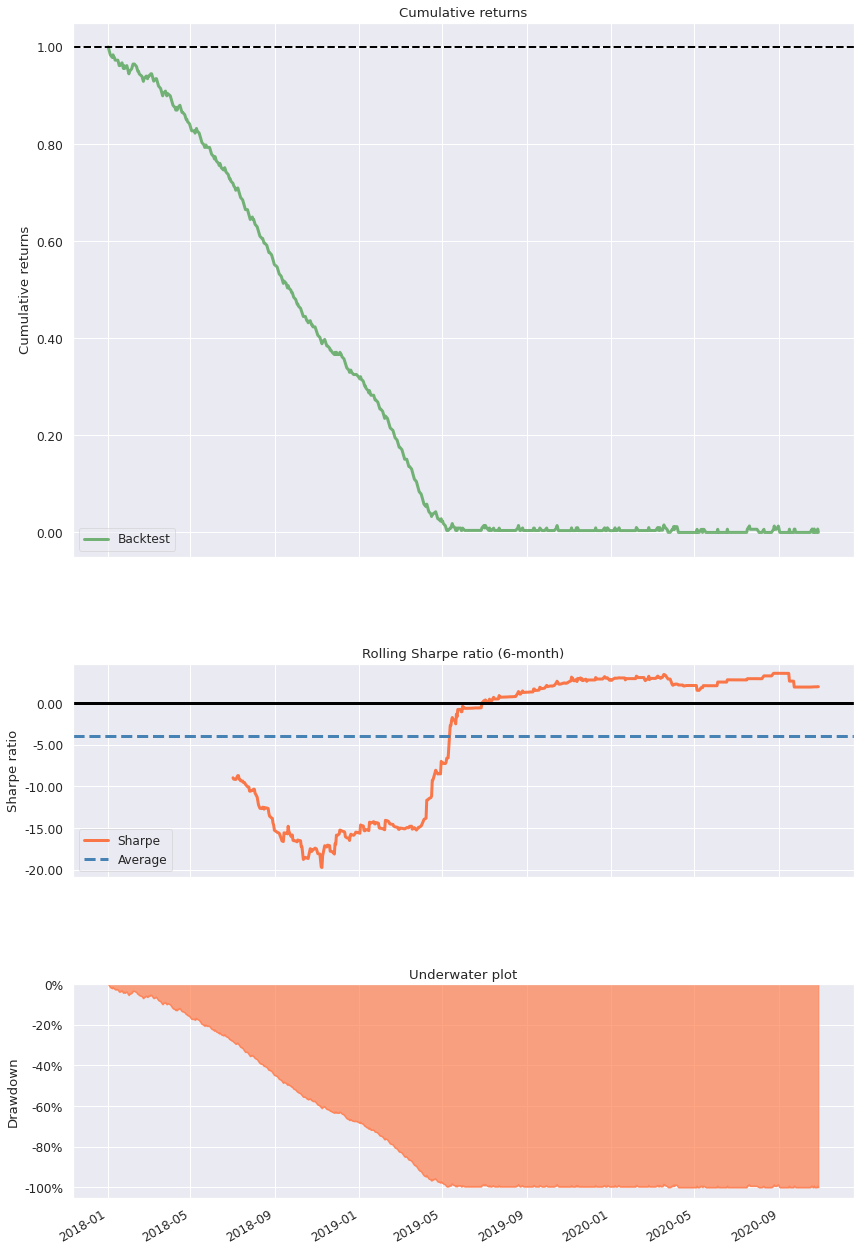

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

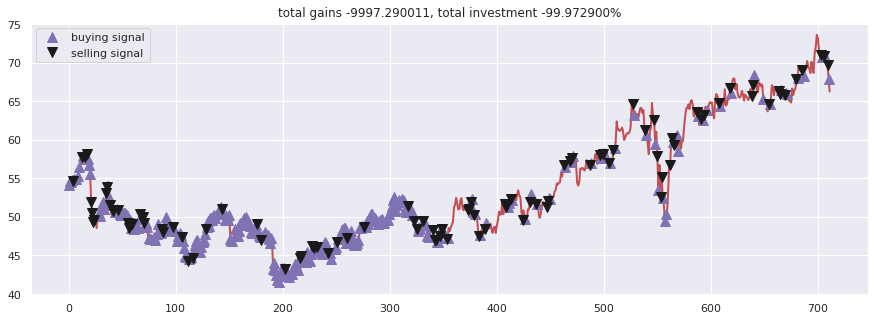

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## Curiosity Q-learning agent

In [ ]:
from collections import deque
import random


df= df_full.copy()
name = 'Curiosity Q-learning agent'

class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.state_size))
        self.ACTION = tf.placeholder(tf.float32, (None))
        self.REWARD = tf.placeholder(tf.float32, (None))
        self.batch_size = tf.shape(self.ACTION)[0]
        
        with tf.variable_scope('curiosity_model'):
            action = tf.reshape(self.ACTION, (-1,1))
            state_action = tf.concat([self.X, action], axis=1)
            save_state = tf.identity(self.Y)
            
            feed = tf.layers.dense(state_action, 32, activation=tf.nn.relu)
            self.curiosity_logits = tf.layers.dense(feed, self.state_size)
            self.curiosity_cost = tf.reduce_sum(tf.square(save_state - self.curiosity_logits), axis=1)
            
            self.curiosity_optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE)\
            .minimize(tf.reduce_mean(self.curiosity_cost))
        
        total_reward = tf.add(self.curiosity_cost, self.REWARD)
        
        with tf.variable_scope("q_model"):
            with tf.variable_scope("eval_net"):
                x_action = tf.layers.dense(self.X, 128, tf.nn.relu)
                self.logits = tf.layers.dense(x_action, self.OUTPUT_SIZE)
            
            with tf.variable_scope("target_net"):
                y_action = tf.layers.dense(self.Y, 128, tf.nn.relu)
                y_q = tf.layers.dense(y_action, self.OUTPUT_SIZE)
            
            q_target = total_reward + self.GAMMA * tf.reduce_max(y_q, axis=1)
            action = tf.cast(self.ACTION, tf.int32)
            action_indices = tf.stack([tf.range(self.batch_size, dtype=tf.int32), action], axis=1)
            q = tf.gather_nd(params=self.logits, indices=action_indices)
            self.cost = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.optimizer = tf.train.RMSPropOptimizer(self.LEARNING_RATE).minimize(
            self.cost, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "q_model/eval_net"))
            
        t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/target_net')
        e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_model/eval_net')
        self.target_replace_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()
            
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action
    
    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        actions = np.array([a[1] for a in replay])
        rewards = np.array([a[2] for a in replay])
        new_states = np.array([a[3] for a in replay])
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.target_replace_op)
            
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
        })
        
        if (self.T_COPY + 1) % self.COPY == 0:
            self.sess.run(self.curiosity_optimizer, feed_dict = {
                self.X: states, self.Y: new_states, self.ACTION: actions, self.REWARD: rewards
            })
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [ ]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = ITER, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 313.679985.3, cost: 3949.250000, total money: 10260.889984
epoch: 20, total rewards: 137.887973.3, cost: 2153.094238, total money: 9674.877970
epoch: 30, total rewards: 1174.204032.3, cost: 40248.078125, total money: 6727.784019
epoch: 40, total rewards: 221.815992.3, cost: 9630.276367, total money: 7097.945988
epoch: 50, total rewards: 720.148033.3, cost: 26852.031250, total money: 9358.158029
epoch: 60, total rewards: 1723.321993.3, cost: 6657.975586, total money: 5968.931993
epoch: 70, total rewards: 767.209986.3, cost: 25942.484375, total money: 10350.229981
epoch: 80, total rewards: 2011.251909.3, cost: 13944.191406, total money: 8204.231890
epoch: 90, total rewards: 2480.433996.3, cost: 331952.625000, total money: 12426.703996
epoch: 100, total rewards: 74.444005.3, cost: 220540.406250, total money: 9863.674004
epoch: 110, total rewards: -255.099977.3, cost: 24802.890625, total money: 6595.010016
epoch: 120, total rewards: 2266.996046.3, cost: 13300.7167

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 54.680000, total balance 9945.320000
day 2, sell 1 unit at price 54.490002, investment -0.347473 %, total balance 9999.810002,
day 12: buy 1 unit at price 57.790001, total balance 9942.020001
day 13: buy 1 unit at price 57.950001, total balance 9884.070000
day 14, sell 1 unit at price 57.939999, investment 0.259557 %, total balance 9942.009999,
day 15, sell 1 unit at price 57.730000, investment -0.379639 %, total balance 9999.739999,
day 20: buy 1 unit at price 55.500000, total balance 9944.239999
day 21: buy 1 unit at price 51.869999, total balance 9892.370000
day 22, sell 1 unit at price 50.470001, investment -9.063061 %, total balance 9942.840001,
day 23, sell 1 unit at price 49.290001, investment -4.973970 %, total balance 9992.130002,
day 28: buy 1 unit at price 50.470001, total balance 9941.660001
day 29: buy 1 unit at price 50.150002, total balance 9891.509999
day 30, sell 1 unit at price 50.799999, investment 0.653850 %, total balance 9942.309998,
day

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,-14.1%
Cumulative returns,-35.0%
Annual volatility,8.8%
Sharpe ratio,-1.69
Calmar ratio,-0.39
Stability,0.94
Max drawdown,-36.3%


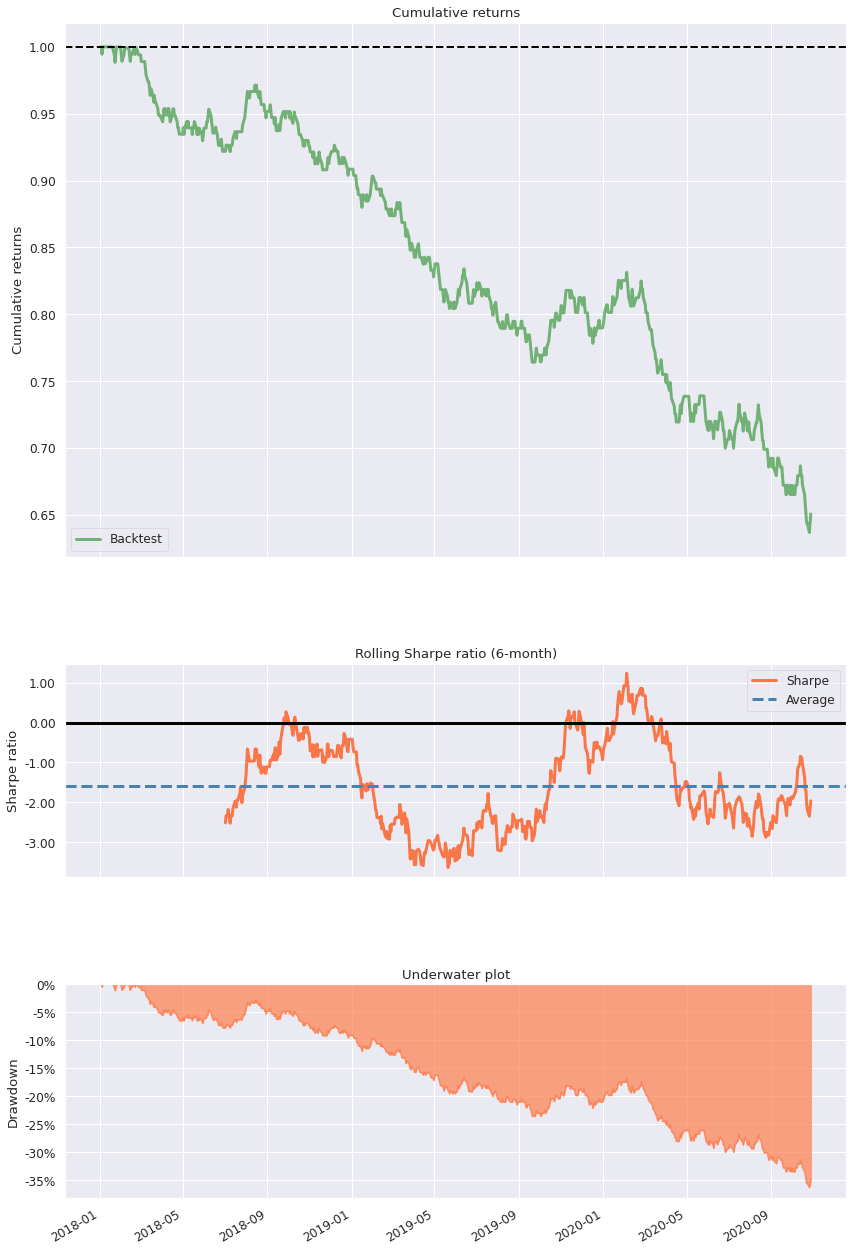

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

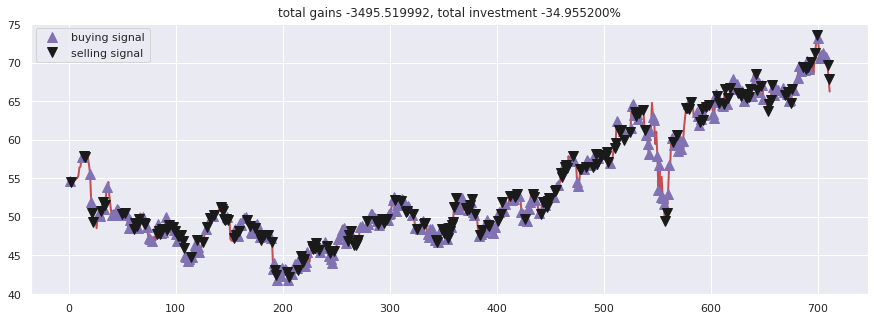

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## Neuro-evolution agent

In [ ]:
df= df_full.copy()
name = 'Neuro-evolution agent'

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

In [ ]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [ ]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        daily_returns = []
        daily_returns.append(0)
        
        for t in range(0, len(self.trend) - 1, self.skip):
            initial_money_hold = initial_money
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual

In [ ]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [ ]:
fittest_nets = neural_evolve.evolve(50)

epoch 5, fittest individual 0 with accuracy 2.709740
epoch 10, fittest individual 0 with accuracy 5.955140
epoch 15, fittest individual 0 with accuracy 5.955140
epoch 20, fittest individual 0 with accuracy 5.955140
epoch 25, fittest individual 0 with accuracy 5.955140
epoch 30, fittest individual 72 with accuracy 9.772880
epoch 35, fittest individual 0 with accuracy 9.772880
epoch 40, fittest individual 0 with accuracy 9.772880
epoch 45, fittest individual 0 with accuracy 9.772880
epoch 50, fittest individual 0 with accuracy 9.772880


In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
neural_evolve.trend = close
states_buy, states_sell, total_gains, invest, daily_returns = neural_evolve.buy(fittest_nets)

day 2: buy 1 unit at price 54.490002, total balance 9945.509998
day 3: buy 1 unit at price 54.740002, total balance 9890.769996
day 4: buy 1 unit at price 54.689999, total balance 9836.079997
day 5: buy 1 unit at price 54.860001, total balance 9781.219996
day 6: buy 1 unit at price 54.790001, total balance 9726.429995
day 7, sell 1 unit at price 54.959999, investment 0.862538 %, total balance 9781.389994,
day 8: buy 1 unit at price 55.040001, total balance 9726.349993
day 9, sell 1 unit at price 55.310001, investment 1.041284 %, total balance 9781.659994,
day 10, sell 1 unit at price 56.410000, investment 3.145001 %, total balance 9838.069994,
day 11: buy 1 unit at price 56.509998, total balance 9781.559996
day 12: buy 1 unit at price 57.790001, total balance 9723.769995
day 13: buy 1 unit at price 57.950001, total balance 9665.819994
day 14: buy 1 unit at price 57.939999, total balance 9607.879995
day 15: buy 1 unit at price 57.730000, total balance 9550.149995
day 17, sell 1 unit at 

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,-5.1%
Cumulative returns,-13.7%
Annual volatility,7.6%
Sharpe ratio,-0.65
Calmar ratio,-0.32
Stability,0.68
Max drawdown,-15.8%


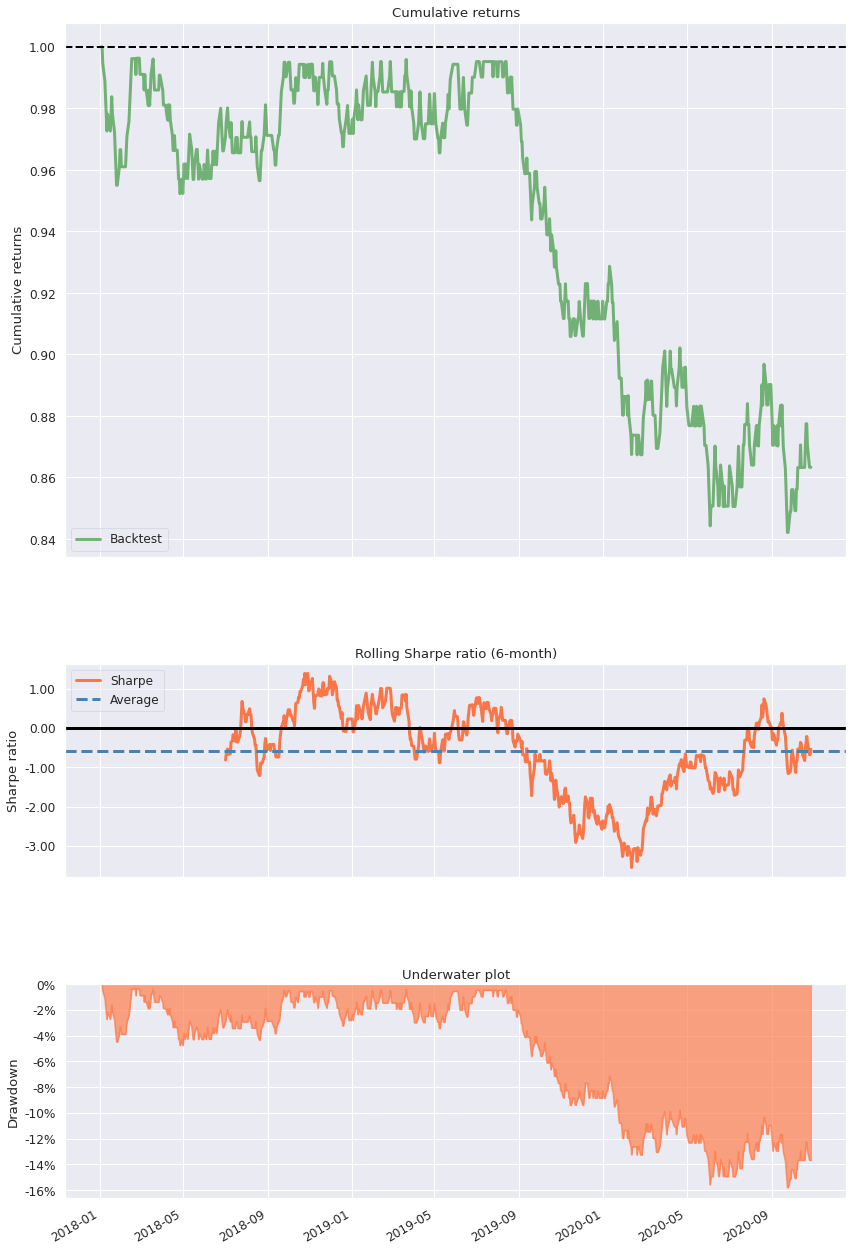

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

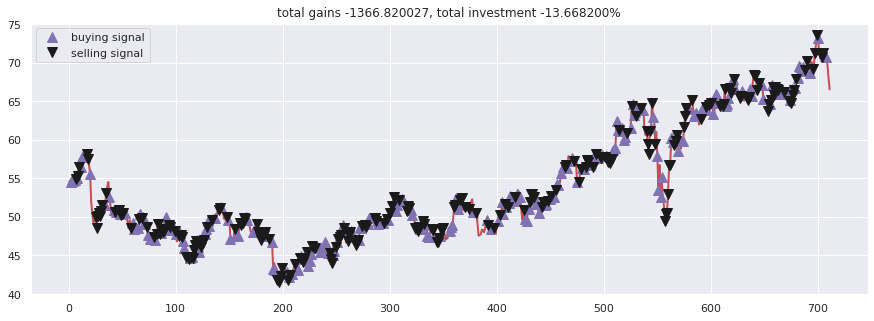

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()

## Deep Evolution Strategy

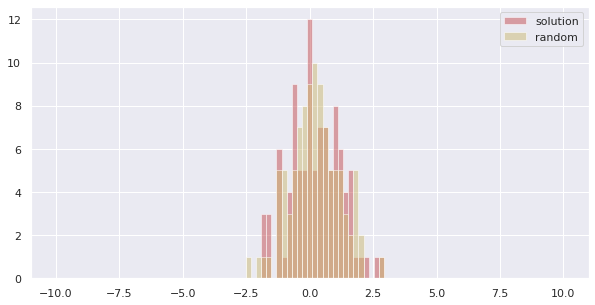

In [ ]:
plt.figure(figsize = (10, 5))
bins = np.linspace(-10, 10, 100)

solution = np.random.randn(100)
w = np.random.randn(100)

plt.hist(solution, bins, alpha = 0.5, label = 'solution', color = 'r')
plt.hist(w, bins, alpha = 0.5, label = 'random', color = 'y')
plt.legend()
plt.show()

In [ ]:
def f(w):
    return -np.sum(np.square(solution - w))


npop = 50
sigma = 0.1
alpha = 0.001

for i in range(5000):

    if (i + 1) % 1000 == 0:
        print(
            'iter %d. w: %s, solution: %s, reward: %f'
            % (i + 1, str(w[-1]), str(solution[-1]), f(w))
        )
    N = np.random.randn(npop, 100)
    R = np.zeros(npop)
    for j in range(npop):
        w_try = w + sigma * N[j]
        R[j] = f(w_try)

    A = (R - np.mean(R)) / np.std(R)
    w = w + alpha / (npop * sigma) * np.dot(N.T, A)

iter 1000. w: 1.561626730682349, solution: 2.2117028069826574, reward: -16.222889
iter 2000. w: 2.2213000462239187, solution: 2.2117028069826574, reward: -0.008719
iter 3000. w: 2.207506976959571, solution: 2.2117028069826574, reward: -0.006138
iter 4000. w: 2.197820516042436, solution: 2.2117028069826574, reward: -0.007251
iter 5000. w: 2.22325676246648, solution: 2.2117028069826574, reward: -0.007501


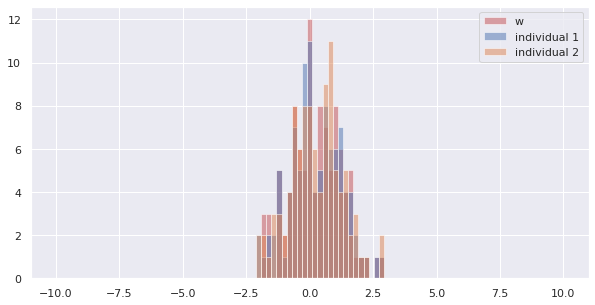

In [ ]:
'''
I want to compare my first two individuals with my real w
'''
plt.figure(figsize=(10,5))

sigma = 0.1
N = np.random.randn(npop, 100)
individuals = []
for j in range(2):
    individuals.append(w + sigma * N[j])
    
    
plt.hist(w, bins, alpha=0.5, label='w',color='r')
plt.hist(individuals[0], bins, alpha=0.5, label='individual 1')
plt.hist(individuals[1], bins, alpha=0.5, label='individual 2')
plt.legend()
plt.show()

In [ ]:
df= df_full.copy()
name = 'Deep Evolution Strategy'

In [ ]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[: t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [ ]:
close = df.Close.values.tolist()
get_state(close, 0, 10)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
get_state(close, 1, 10)

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        -0.192]])

In [ ]:
get_state(close, 2, 10)

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.192,
         0.152]])

In [ ]:
class Deep_Evolution_Strategy:
    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')

In [ ]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [ ]:
window_size = 30
model = Model(window_size, 500, 3)

In [ ]:
initial_money = 10000
starting_money = initial_money
len_close = len(close) - 1
weight = model
skip = 1

state = get_state(close, 0, window_size + 1)
inventory = []
quantity = 0

max_buy = 1
max_sell = 1


def act(model, sequence):
    decision, buy = model.predict(np.array(sequence))
    return np.argmax(decision[0]), int(buy[0])


for t in range(0, len_close, skip):
    action, buy = act(weight, state)
    next_state = get_state(close, t + 1, window_size + 1)
    if action == 1 and initial_money >= close[t]:
        if buy < 0:
            buy = 1
        if buy > max_buy:
            buy_units = max_buy
        else:
            buy_units = buy
        total_buy = buy_units * close[t]
        initial_money -= total_buy
        inventory.append(total_buy)
        quantity += buy_units
    elif action == 2 and len(inventory) > 0:
        if quantity > max_sell:
            sell_units = max_sell
        else:
            sell_units = quantity
        quantity -= sell_units
        total_sell = sell_units * close[t]
        initial_money += total_sell

    state = next_state
((initial_money - starting_money) / starting_money) * 100

-2.438380309999811

In [ ]:
import time


class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(
        self, model, money, max_buy, max_sell, close, window_size, skip
    ):
        self.window_size = window_size
        self.skip = skip
        self.close = close
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        len_close = len(self.close) - 1

        self.model.weights = weights
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, len_close, self.skip):
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        len_close = len(self.close) - 1
        state = get_state(self.close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        daily_returns = []
        daily_returns.append(0)
        quantity = 0
        for t in range(0, len_close, self.skip):
            initial_money_hold = initial_money
            action, buy = self.act(state)
            next_state = get_state(self.close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= self.close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * self.close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * self.close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state
            returns = (initial_money/initial_money_hold - 1)*100
            daily_returns.append(returns)

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.savefig(name+'.png')
        plt.show()
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, daily_returns

In [ ]:
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(
    model = model,
    money = 10000,
    max_buy = 1,
    max_sell = 1,
    close = close,
    window_size = window_size,
    skip = 1,
)

In [ ]:
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 2.776680
iter 20. reward: 3.278440
iter 30. reward: 2.636640
iter 40. reward: 2.650540
iter 50. reward: 4.159560
iter 60. reward: 2.552440
iter 70. reward: 2.493800
iter 80. reward: 4.080440
iter 90. reward: 5.946200
iter 100. reward: 2.499000
iter 110. reward: -3.651840
iter 120. reward: 3.111900
iter 130. reward: 3.373140
iter 140. reward: -5.273120
iter 150. reward: 9.276960
iter 160. reward: 5.377520
iter 170. reward: 7.769720
iter 180. reward: 7.791880
iter 190. reward: 4.718660
iter 200. reward: 9.813160
iter 210. reward: 8.015460
iter 220. reward: 10.140500
iter 230. reward: 9.501800
iter 240. reward: 11.728540
iter 250. reward: 13.385040
iter 260. reward: 8.554800
iter 270. reward: 12.904080
iter 280. reward: 6.591300
iter 290. reward: 7.026400
iter 300. reward: 3.320300
iter 310. reward: 10.378440
iter 320. reward: 12.383980
iter 330. reward: 7.122360
iter 340. reward: 11.538460
iter 350. reward: 5.263840
iter 360. reward: 15.062300
iter 370. reward: 16.557380

day 0: buy 1 units at price 54.160000, total balance 9945.840000
day 1: buy 1 units at price 54.680000, total balance 9891.160000
day 2: buy 1 units at price 54.490002, total balance 9836.669998
day 3: buy 1 units at price 54.740002, total balance 9781.929996
day 4: buy 1 units at price 54.689999, total balance 9727.239997
day 5: buy 1 units at price 54.860001, total balance 9672.379996
day 6: buy 1 units at price 54.790001, total balance 9617.589995
day 7: buy 1 units at price 54.959999, total balance 9562.629996
day 8, sell 1 units at price 55.040001, investment 1.624817 %, total balance 9617.669997,
day 9: buy 1 units at price 55.310001, total balance 9562.359996
day 10, sell 1 units at price 56.410000, investment 3.163862 %, total balance 9618.769996,
day 12, sell 1 units at price 57.790001, investment 6.056155 %, total balance 9676.559997,
day 13, sell 1 units at price 57.950001, investment 5.864083 %, total balance 9734.509998,
day 15, sell 1 units at price 57.730000, investment 

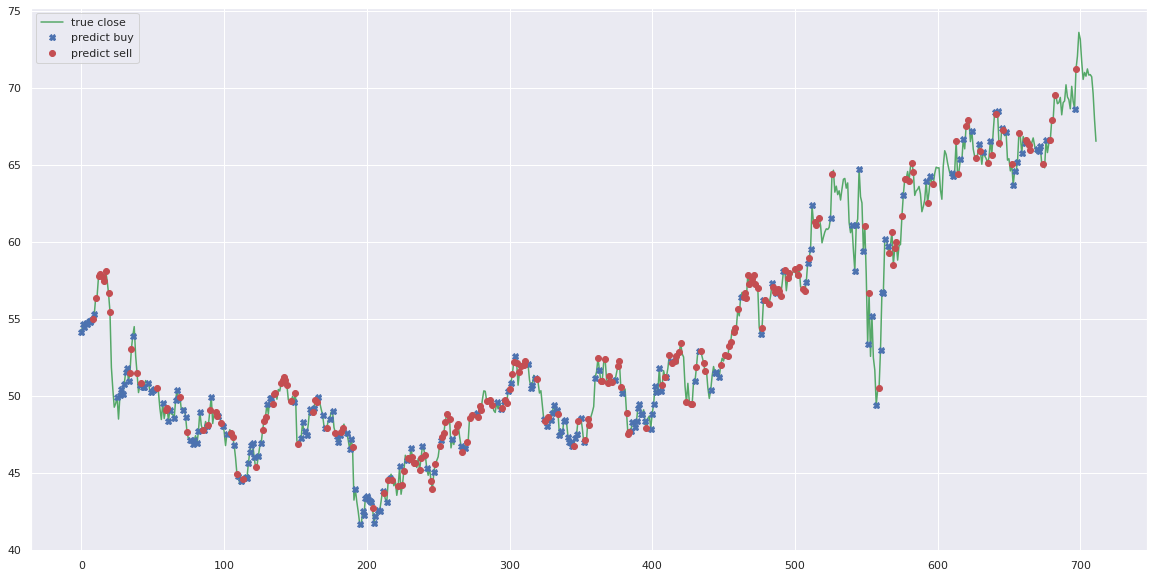

In [ ]:
df = df_full_test.copy()
close = df.Close.values.tolist()
agent.close = close
states_buy, states_sell, total_gains, invest, daily_returns = agent.buy()

Start date,2018-01-02
End date,2020-10-28
Total months,33
,Backtest
Annual return,1.4%
Cumulative returns,3.9%
Annual volatility,7.0%
Sharpe ratio,0.23
Calmar ratio,0.07
Stability,0.38
Max drawdown,-19.4%


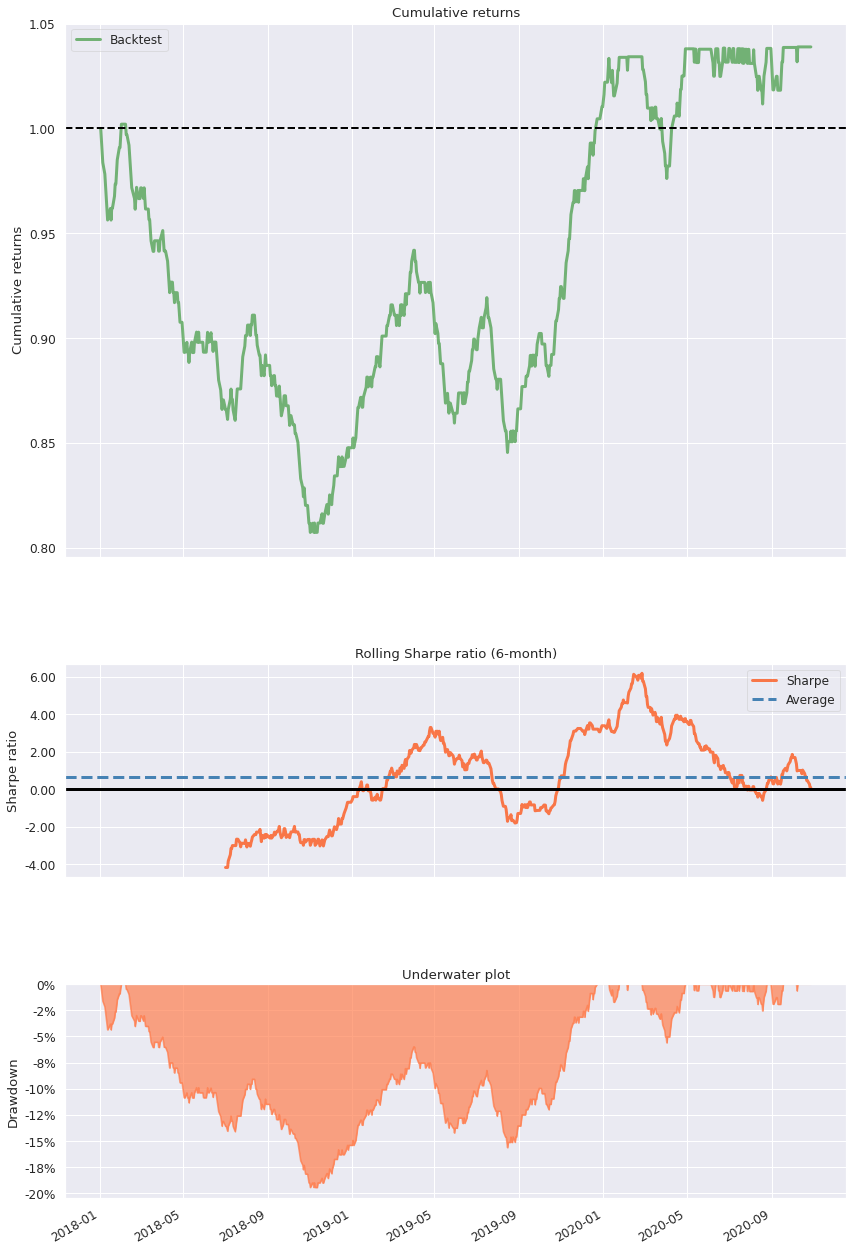

In [ ]:
daily_returns_df = pd.Series(daily_returns, index=df.Date.values)
daily_returns_df = daily_returns_df/100
with pyfolio.plotting.plotting_context(font_scale=1.1):
 pyfolio.create_simple_tear_sheet(returns = daily_returns_df, set_context=False)

# Summary

##  Percentage of cumulative returns

* **Turtle Trading agent: 1.70%**
* Moving Average agent: -0.68%
* Signal Rolling agent: -0.55%
* **Policy Gradient agent: 0.47%**
* Q-learning agent: -0.43%
* **F-Q learning: 0.08%**
* **F-Q with choice trace: 0.26%**
* F-Q greedy learning: -1.46%
* **Evolution Strategy agent: 16.39%**
* **Double Q-learning agent: 0.61%**
* Duel Q-learning agent: -65.71%
* Actor-critic agent: -99.97%
* Curiosity Q-learning agent: -34.96%
* Neuro-evolution agent: -13.67%
* **Deep Evolution Strategy: 3.88%**

## Conclusions

Out of 15 virtual agents tested, only 7 of them could profit from their trading strategy. It is significantly higher the trading strategy of the Evolution Strategy agent with a cumulative return of 16.39%. Interestingly this strategy doesn't seem to improve when combined with Deep Learning as in the Deep Evolution Strategy. It might be due to the limited data points, since a Deep Learning agent is particularly good when the number of data is very high. Thus, the Deep Evolution Strategy might be overfitting some data turning in a not as good strategy as the simple Evolution Strategy agents.

It is important to mention that this notebook is constrained to certain conditions and that it could be greatly improved, such as finding the optimal parameters for better learning of each agents, including more data for the states and not only the close price of the stock, include more stocks for a more stable portfolio, using predictive signals from raw data as part of the agent states, use ensemble models for a trading strategy, and a long etcetera. I hope you find this notebook interesting and useful, and you're welcome to test different single stocks, dates, evaluation metrics and agents.